# Description of the final project

## Introduction

In this project, you are going to work with the dataset based on the census data extracted from the 1994 and 1995 current population surveys conducted by the U.S. Census Bureau. Your goal is to predict level of income of a person: "- 50000" (means less than \$50k/year) or "50000+" (means more than \$50k/year). The data is split into train (`train.csv`) and test (`test.csv`) parts. You should use train part to train the models, and test part to estimate their final quality. The best quality on the test dataset should be your final result.

The description of the data is available here: https://archive.ics.uci.edu/ml/datasets/Census-Income+%28KDD%29

_Citation:_

* _Dua, D. and Graff, C. (2019). UCI Machine Learning Repository [http://archive.ics.uci.edu/ml]. Irvine, CA: University of California, School of Information and Computer Science._

## Detailed Task Description

The solution should have the following parts:

### [25%] 1. Data exploration

* 1.1. (8%) Which metric are you going to use to evaluate the performance of the model and why?
* 1.2. (8%) Which validation strategy are you going to use and why? Apply it to the data on the preprocessing step
* 1.3. (9%) Explore which features do you have, what is their distribution and connection to the target. Perform feature selection techniques such as PCA, and feature engineering, if necessary. Explain your decisions



> ### Data downloading and reading

In [1]:
# !pip install wget
# !pip install shap
# !pip install scikit-learn -U
# !pip install --extra-index-url=https://pypi.nvidia.com cudf-cu11 cuml-cu11
# !pip install catboost
# !pip install category_encoders
# !pip install lime

In [2]:
import os
import wget

import pandas as pd
import numpy as np
import shap

from sklearn.model_selection import StratifiedKFold, GridSearchCV, cross_val_score
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder
from sklearn.ensemble import IsolationForest, RandomForestClassifier, StackingClassifier
# from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, balanced_accuracy_score, matthews_corrcoef, roc_auc_score
from sklearn.cluster import HDBSCAN
# from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from sklearn.feature_selection import RFE
from sklearn.inspection import PartialDependenceDisplay

# from cuml.cluster import hdbscan
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from category_encoders import WOEEncoder
from imblearn.combine import SMOTETomek
from lime.lime_tabular import LimeTabularExplainer

from tqdm.notebook import tqdm
import seaborn as sns
import matplotlib.pylab as plt
%matplotlib inline

In [3]:
files = {'train.csv':
         'https://drive.google.com/u/0/uc?id=1R6teStyCCPrsaeaLwLV63lWEuUtNwdka&export=download',
         'test.csv':
         'https://drive.google.com/u/0/uc?id=1xbh2RtHh_vHMdtOQjHGDBmy1pwmqT7o3&export=download"',
         'names.csv':
         'https://drive.google.com/u/0/uc?id=1Q2GCBa5c7z5yB0EkFbdxL9U9vEZX1wlm&export=download'}

for file, url in files.items():
    if os.path.exists(file):
        print(f'File {file} already exists... \tDownload skipped')
    else:
        print(f'Dowloading {file}...', end='\t')
        wget.download(url, file)
        print('Done')


File train.csv already exists... 	Download skipped
File test.csv already exists... 	Download skipped
File names.csv already exists... 	Download skipped


In [4]:
with open('names.csv') as file:
    description = file.read()

In [5]:
print(description[2660:3120])


| Basic statistics for this data set:
|
| Number of instances data = 199523
|    Duplicate or conflicting instances : 46716
| Number of instances in test = 99762
|    Duplicate or conflicting instances : 20936
| Class probabilities for income-projected.test file
| Probability for the label '- 50000' : 93.80%
| Probability for the label '50000+' : 6.20%
| Majority accuracy: 93.80% on value - 50000
| Number of attributes = 40 (continuous : 7 nominal : 33)
|


In [6]:
columns = [
    'age',
    'class of worker',
    'detailed industry recode',
    'detailed occupation recode',
    'education',
    'wage per hour',
    'enroll in edu inst last wk',
    'marital stat',
    'major industry code',
    'major occupation code',
    'race',
    'hispanic origin',
    'sex',
    'member of a labor union',
    'reason for unemployment',
    'full or part time employment stat',
    'capital gains',
    'capital losses',
    'dividends from stocks',
    'tax filer stat',
    'region of previous residence',
    'state of previous residence',
    'detailed household and family stat',
    'detailed household summary in household',
    'instance weight',
    'migration code-change in msa',
    'migration code-change in reg',
    'migration code-move within reg',
    'live in this house 1 year ago',
    'migration prev res in sunbelt',
    'num persons worked for employer',
    'family members under 18',
    'country of birth father',
    'country of birth mother',
    'country of birth self',
    'citizenship',
    'own business or self employed',
    "fill inc questionnaire for veteran admin",
    "veterans benefits",
    'weeks worked in year',
    'year',
    'target'
]

In [7]:
columns = [column.replace(' ', '_') for column in columns]

In [8]:
train = pd.read_csv('train.csv', names=columns)
test = pd.read_csv('test.csv', names=columns)

In [9]:
train.head(3)

age                  class_of_worker  detailed_industry_recode  \
0   73                  Not in universe                         0   
1   58   Self-employed-not incorporated                         4   
2   18                  Not in universe                         0   

   detailed_occupation_recode                    education  wage_per_hour  \
0                           0         High school graduate              0   
1                          34   Some college but no degree              0   
2                           0                   10th grade              0   

  enroll_in_edu_inst_last_wk    marital_stat           major_industry_code  \
0            Not in universe         Widowed   Not in universe or children   
1            Not in universe        Divorced                  Construction   
2                High school   Never married   Not in universe or children   

                  major_occupation_code  ... country_of_birth_father  \
0                       Not in universe  ...           United-States   
1   Precision production craft & repair  ...           United-States   
2                       Not in universe  ...                 Vietnam   

  country_of_birth_mother country_of_birth_self  \
0           United-States         United-States   
1           United-States         United-States   
2                 Vietnam               Vietnam   

                            citizenship own_business_or_self_employed  \
0     Native- Born in the United States                             0   
1     Native- Born in the United States                             0   
2   Foreign born- Not a citizen of U S                              0   

  fill_inc_questionnaire_for_veteran_admin  veterans_benefits  \
0                          Not in universe                  2   
1                          Not in universe                  2   
2                          Not in universe                  2   

   weeks_worked_in_year  year     target  
0                     0    95   - 50000.  
1                    52    94   - 50000.  
2                     0    95   - 50000.  

[3 rows x 42 columns]

> #### 1.1. Metric selection

Target distribution


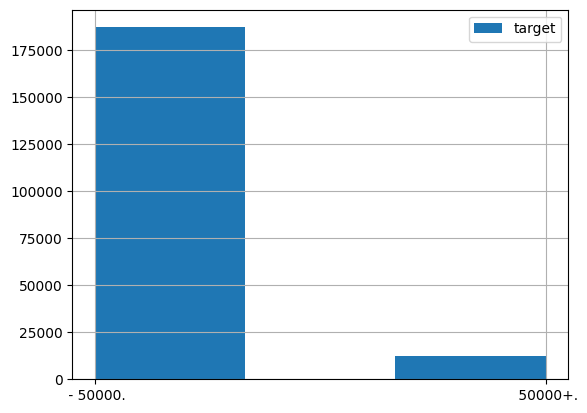

In [10]:
print('Target distribution')
train.target.hist(bins=3, legend=True, grid=True);

In [11]:
target_distribution = pd.DataFrame(train.target.value_counts()).reset_index()
target_distribution['share_%'] = target_distribution.iloc[:, 1] / train.shape[0] * 100
target_distribution['imbalance_ratio'] = (target_distribution['share_%']
                                          / (100 - target_distribution['share_%']))
target_distribution

target   count    share_%  imbalance_ratio
0   - 50000.  187141  93.794199        15.113956
1    50000+.   12382   6.205801         0.066164

When dealing with binary classification we may generally rely on accuracy score. However, the basic dataset description and the target distribution analysis above have shown that we are dealing with highly imbalanced data, for which accuracy score cannot be a proper metric. Obviously, in our case even if a model classifies any object as `'- 50000.'` we shall get accuracy at almost 0.94 which gives no information about real model performance.

For imbalanced data we can consider precision or recall metrics depending on which type of error we need to minimize. Precision is appropriate when the objective is to minimize false positives, recall is appropriate when the objective is to minimize false negatives. We may also use a harmonic mean of precision and recall F-score or its weighted version F $_\beta$-score if we do not care about true negatives.

However, from our task it cannot be said which type of error should be avoided and whether true negatives are important, therefore we shall concentrate on precision-recall trade-off and assume that true negatives should be taken into account.

In this case we arrive at using either balanced accuracy, MCC (Matthews Correlation Coefficient) or AUC-ROC score.

> #### 1.2. Validation strategy

Dealing with highly imbalanced data we shall apply stratified cross-validation to ensures that each fold has the same class distribution as the entire dataset. This will make the training and evaluation process more representative of the overall dataset.

> #### 1.3. Feature exploration

##### Overview

In [12]:
# Basic description from supplied file

print(description[3120:6095])
print(description[6320:6620])

 Information about .data file : 
|   91 distinct values for attribute #0 (age) continuous
|    9 distinct values for attribute #1 (class of worker) nominal
|   52 distinct values for attribute #2 (detailed industry recode) nominal
|   47 distinct values for attribute #3 (detailed occupation recode) nominal
|   17 distinct values for attribute #4 (education) nominal
| 1240 distinct values for attribute #5 (wage per hour) continuous
|    3 distinct values for attribute #6 (enroll in edu inst last wk) nominal
|    7 distinct values for attribute #7 (marital stat) nominal
|   24 distinct values for attribute #8 (major industry code) nominal
|   15 distinct values for attribute #9 (major occupation code) nominal
|    5 distinct values for attribute #10 (race) nominal
|   10 distinct values for attribute #11 (hispanic origin) nominal
|    2 distinct values for attribute #12 (sex) nominal
|    3 distinct values for attribute #13 (member of a labor union) nominal
|    6 distinct values for att

In [13]:
# general dataset info
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 199523 entries, 0 to 199522
Data columns (total 42 columns):
 #   Column                                    Non-Null Count   Dtype  
---  ------                                    --------------   -----  
 0   age                                       199523 non-null  int64  
 1   class_of_worker                           199523 non-null  object 
 2   detailed_industry_recode                  199523 non-null  int64  
 3   detailed_occupation_recode                199523 non-null  int64  
 4   education                                 199523 non-null  object 
 5   wage_per_hour                             199523 non-null  int64  
 6   enroll_in_edu_inst_last_wk                199523 non-null  object 
 7   marital_stat                              199523 non-null  object 
 8   major_industry_code                       199523 non-null  object 
 9   major_occupation_code                     199523 non-null  object 
 10  race                

In [14]:
# number of missing values
train.isna().sum().sum()

0

In [15]:
# dataset description // numerical
train.describe()

age  detailed_industry_recode  detailed_occupation_recode  \
count  199523.000000             199523.000000               199523.000000   
mean       34.494199                 15.352320                   11.306556   
std        22.310895                 18.067129                   14.454204   
min         0.000000                  0.000000                    0.000000   
25%        15.000000                  0.000000                    0.000000   
50%        33.000000                  0.000000                    0.000000   
75%        50.000000                 33.000000                   26.000000   
max        90.000000                 51.000000                   46.000000   

       wage_per_hour  capital_gains  capital_losses  dividends_from_stocks  \
count  199523.000000   199523.00000   199523.000000          199523.000000   
mean       55.426908      434.71899       37.313788             197.529533   
std       274.896454     4697.53128      271.896428            1984.163658   
min         0.000000        0.00000        0.000000               0.000000   
25%         0.000000        0.00000        0.000000               0.000000   
50%         0.000000        0.00000        0.000000               0.000000   
75%         0.000000        0.00000        0.000000               0.000000   
max      9999.000000    99999.00000     4608.000000           99999.000000   

       instance_weight  num_persons_worked_for_employer  \
count    199523.000000                    199523.000000   
mean       1740.380269                         1.956180   
std         993.768156                         2.365126   
min          37.870000                         0.000000   
25%        1061.615000                         0.000000   
50%        1618.310000                         1.000000   
75%        2188.610000                         4.000000   
max       18656.300000                         6.000000   

       own_business_or_self_employed  veterans_benefits  weeks_worked_in_year  \
count                  199523.000000      199523.000000         199523.000000   
mean                        0.175438           1.514833             23.174897   
std                         0.553694           0.851473             24.411488   
min                         0.000000           0.000000              0.000000   
25%                         0.000000           2.000000              0.000000   
50%                         0.000000           2.000000              8.000000   
75%                         0.000000           2.000000             52.000000   
max                         2.000000           2.000000             52.000000   

                year  
count  199523.000000  
mean       94.499672  
std         0.500001  
min        94.000000  
25%        94.000000  
50%        94.000000  
75%        95.000000  
max        95.000000

In [16]:
# dataset description // categorical
train.describe(include='object')

class_of_worker              education enroll_in_edu_inst_last_wk  \
count             199523                 199523                     199523   
unique                 9                     17                          3   
top      Not in universe   High school graduate            Not in universe   
freq              100245                  48407                     186943   

          marital_stat           major_industry_code major_occupation_code  \
count           199523                        199523                199523   
unique               7                            24                    15   
top      Never married   Not in universe or children       Not in universe   
freq             86485                        100684                100684   

          race hispanic_origin      sex member_of_a_labor_union  ...  \
count   199523          199523   199523                  199523  ...   
unique       5              10        2                       3  ...   
top      White       All other   Female         Not in universe  ...   
freq    167365          171907   103984                  180459  ...   

       migration_code-move_within_reg      live_in_this_house_1_year_ago  \
count                          199523                             199523   
unique                             10                                  3   
top                                 ?   Not in universe under 1 year old   
freq                            99696                             101212   

       migration_prev_res_in_sunbelt family_members_under_18  \
count                         199523                  199523   
unique                             4                       5   
top                                ?         Not in universe   
freq                           99696                  144232   

       country_of_birth_father country_of_birth_mother country_of_birth_self  \
count                   199523                  199523                199523   
unique                      43                      43                    43   
top              United-States           United-States         United-States   
freq                    159163                  160479                176989   

                               citizenship  \
count                               199523   
unique                                   5   
top      Native- Born in the United States   
freq                                176992   

       fill_inc_questionnaire_for_veteran_admin     target  
count                                    199523     199523  
unique                                        3          2  
top                             Not in universe   - 50000.  
freq                                     197539     187141  

[4 rows x 29 columns]

In [17]:
# proportion of unique values
train.nunique() / train.shape[0] * 100

age                                          0.045609
class_of_worker                              0.004511
detailed_industry_recode                     0.026062
detailed_occupation_recode                   0.023556
education                                    0.008520
wage_per_hour                                0.621482
enroll_in_edu_inst_last_wk                   0.001504
marital_stat                                 0.003508
major_industry_code                          0.012029
major_occupation_code                        0.007518
race                                         0.002506
hispanic_origin                              0.005012
sex                                          0.001002
member_of_a_labor_union                      0.001504
reason_for_unemployment                      0.003007
full_or_part_time_employment_stat            0.004010
capital_gains                                0.066158
capital_losses                               0.056635
dividends_from_stocks       

In [18]:
number_columns = train.select_dtypes(exclude='object').columns
object_columns = train.select_dtypes(include='object').columns
train.shape, number_columns.shape, object_columns.shape

((199523, 42), (13,), (29,))

Brief analysis has shown that there are no missing values (NaN).
Though, some categorical columns are already encoded and contain numeric values.

We can ignore column `'year'` as it contains static values corresponding to the year of data collection: 94 and 95.
Additionally, as per dataset description, for classsification purposes we have to ignore column `'instance weight'`.

Let us also perform label encoding for the target.
Resulting column grouping is give below.

In [19]:
target_column = 'target'
ignore_columns = ['instance_weight', 'year']
encoded_object_columns = ['detailed_industry_recode', 'detailed_occupation_recode',
                          'own_business_or_self_employed', 'veterans_benefits']

In [20]:
def reduction(dataframe: pd.DataFrame, columns):
    dataframe.drop(columns, axis=1, inplace=True)
    return dataframe


def binary_encoding(dataframe: pd.DataFrame, columns):
    for column in columns:
        dataframe[column] = LabelEncoder().fit_transform(dataframe[column])
    return dataframe


def column_groupnig(dataframe: pd.DataFrame,
                    encoded_object_columns=encoded_object_columns,
                    target_column=target_column):

    number_columns = dataframe.select_dtypes(exclude='object').columns
    object_columns = dataframe.select_dtypes(include='object').columns
    number_columns = [column for column in number_columns
                    if column not in encoded_object_columns and column != target_column]
    object_columns = list(object_columns) + encoded_object_columns

    print(f'Numerical columns: {len(number_columns)} \
          \nCategorical columns: {len(object_columns)} \
          \nDataset shape: {dataframe.shape}')
    return number_columns, object_columns, number_columns + object_columns

In [21]:
train, test = reduction(train, ignore_columns), reduction(test, ignore_columns)
train, test = binary_encoding(train, [target_column]), binary_encoding(test, [target_column])

In [22]:
number_columns, object_columns, all_columns = column_groupnig(train)

Numerical columns: 7           
Categorical columns: 32           
Dataset shape: (199523, 40)


##### Duplicated and conflicting instances

In [23]:
duplicates_num_no_target = train[train.duplicated(subset = number_columns + object_columns)].shape[0]
duplicates_num_with_target = train[train.duplicated(subset = number_columns + object_columns + [target_column])].shape[0]
(print('Number of duplictes and share (exclusive of target): ',
       duplicates_num_no_target, duplicates_num_no_target / train.shape[0] * 100))
(print('Number of duplictes and share (inclusive of target): ',
       duplicates_num_with_target, duplicates_num_with_target / train.shape[0] * 100))

Number of duplictes and share (exclusive of target):  46716 23.413842013201485
Number of duplictes and share (inclusive of target):  46627 23.369235626970326


Search for duplicates has shown that approx. 1/4 of the train dataset is represented by duplicated records (`keep=False` not used). This aligns with the basic dataset description provided above. Also we can see that there is a certain number of conflicts where identical records fall into different classes.

For now we leave the duplicates intact and shall subject them to clasterization later on. However we need to clean the data from conflicts.

In [24]:
def conflict_resolution(dataframe: pd.DataFrame, subset, target_column=target_column):
    columns = dataframe.columns
    target = dataframe[target_column]
    grouped_duplicates = dataframe[dataframe.duplicated(subset=subset, keep=False)].groupby(target)
    target_1, target_2 = target.min(), target.max()
    group_1 = grouped_duplicates.get_group(target_1)
    group_2 = grouped_duplicates.get_group(target_2)
    conflicting_instances = pd.merge(group_1, group_2, on=subset, how='inner')
    conflict_mapping = dataframe.merge(conflicting_instances, on=subset, how='left', indicator=True)
    dataframe = conflict_mapping[conflict_mapping._merge == 'left_only'][columns]
    return dataframe

Removing conflicts from train and test data.

In [25]:
shape_before = train.shape[0]
train = conflict_resolution(train, number_columns + object_columns)
shape_after = train.shape[0]
print('TRAIN data')
print(f'Shape before:\t{shape_before}, \
       \nShape after:\t{shape_after}, \
       \nConflicting instances removed: {shape_before - shape_after}')

TRAIN data
Shape before:	199523,        
Shape after:	199144,        
Conflicting instances removed: 379


In [26]:
shape_before = test.shape[0]
test = conflict_resolution(test, number_columns + object_columns)
shape_after = test.shape[0]
print('TEST data')
print(f'Shape before:\t{shape_before}, \
       \nShape after:\t{shape_after}, \
       \nConflicting instances removed: {shape_before - shape_after}')

TEST data
Shape before:	99762,        
Shape after:	99643,        
Conflicting instances removed: 119


#### Correlation and distibution of numerical features

In [27]:
def correlation_heatmap(dataset, columns):
    correlation_matrix = dataset[columns].corr()
    plt.figure(figsize=(15, 10))
    plt.imshow(correlation_matrix, cmap='coolwarm', interpolation='nearest', aspect='auto')
    plt.colorbar()
    plt.title('correlation matrix heatmap')
    plt.xticks(range(len(correlation_matrix.columns)), correlation_matrix.columns, rotation=90)
    plt.yticks(range(len(correlation_matrix.columns)), correlation_matrix.columns)
    plt.show()

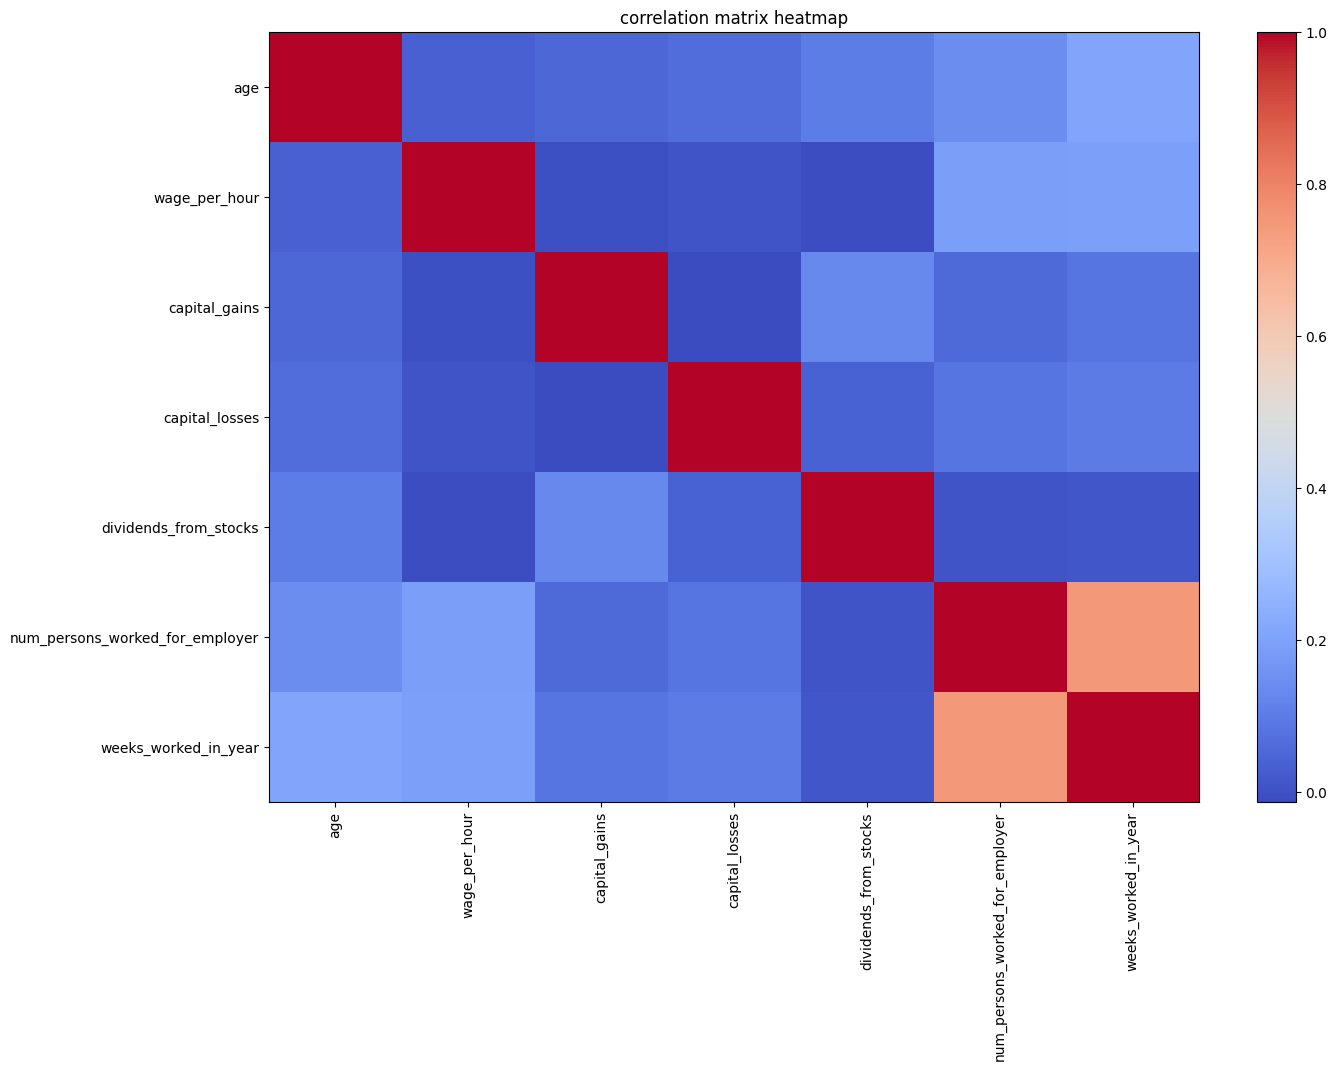

In [28]:
correlation_heatmap(train, number_columns)

In [29]:
train['num_persons_worked_for_employer'].corr(train['weeks_worked_in_year'])

0.747059582314441

In [30]:
corr_mattrix = train[number_columns].corr()
highly_correalted = list(corr_mattrix[(corr_mattrix.abs() > 0.5) & (corr_mattrix.abs() < 1)].stack().index[0])
highly_correalted

['num_persons_worked_for_employer', 'weeks_worked_in_year']

We have two highly correlated features: `'num persons worked for employer'` and `'weeks worked in year'`. Instead of them we can simply create a new one that captures the information from both correlated features such as average, sum, etc. However, for the sake of experiment let us apply PCA and see updated correaltion heatmap.

In [31]:
def pca(dataframe: pd.DataFrame, columns, n_components=1):
    pca = PCA(n_components=n_components)
    dataframe['pca_feature'] = pca.fit_transform(dataframe[columns])
    dataframe = dataframe.drop(columns, axis=1)
    return dataframe

In [32]:
train, test = pca(train, highly_correalted), pca(test, highly_correalted)
number_columns, object_columns, all_columns = column_groupnig(train)

Numerical columns: 6           
Categorical columns: 32           
Dataset shape: (199144, 39)


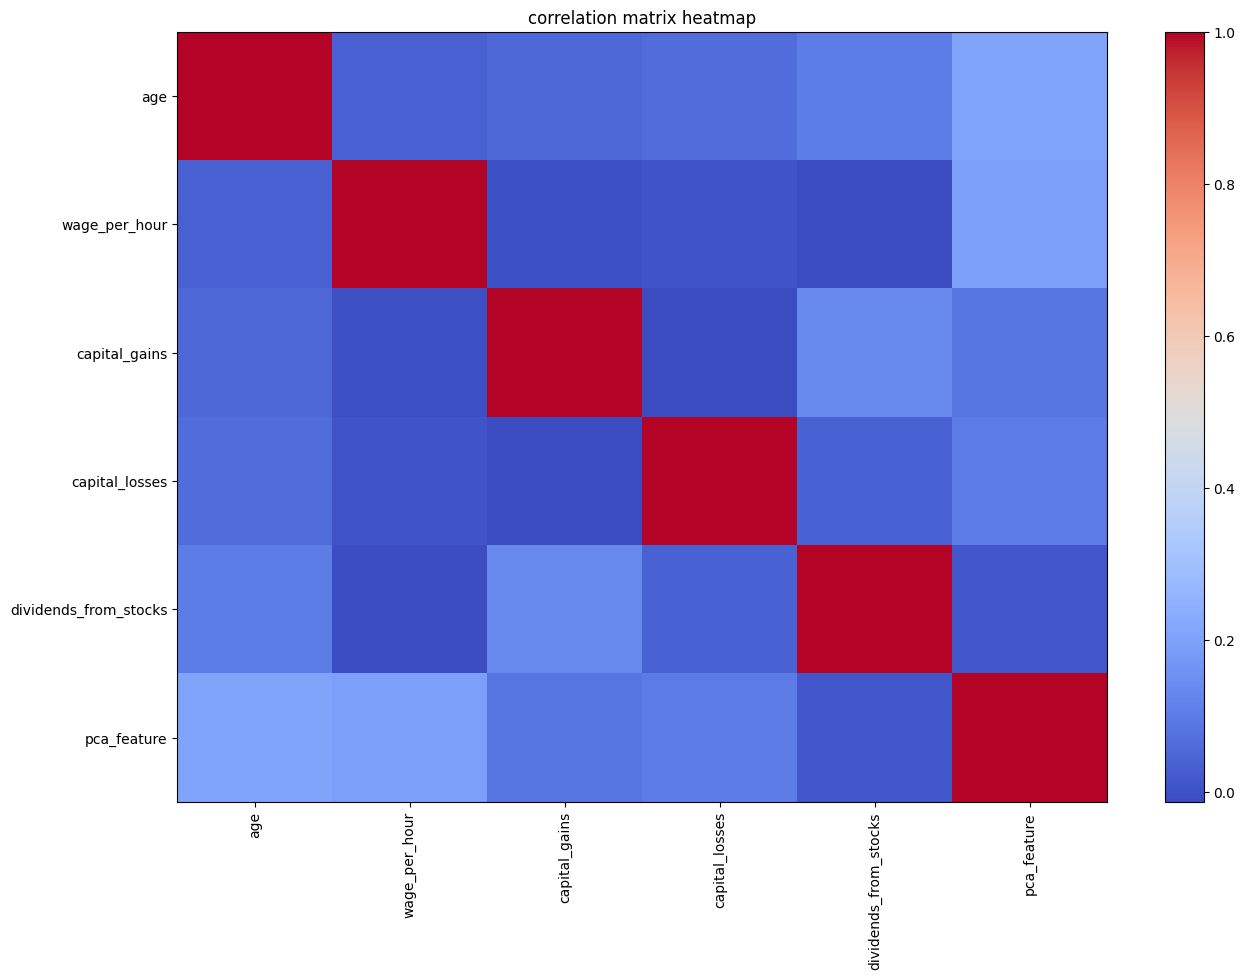

In [33]:
correlation_heatmap(train, number_columns)

Now lets us take a look at the distribution of numerical features.

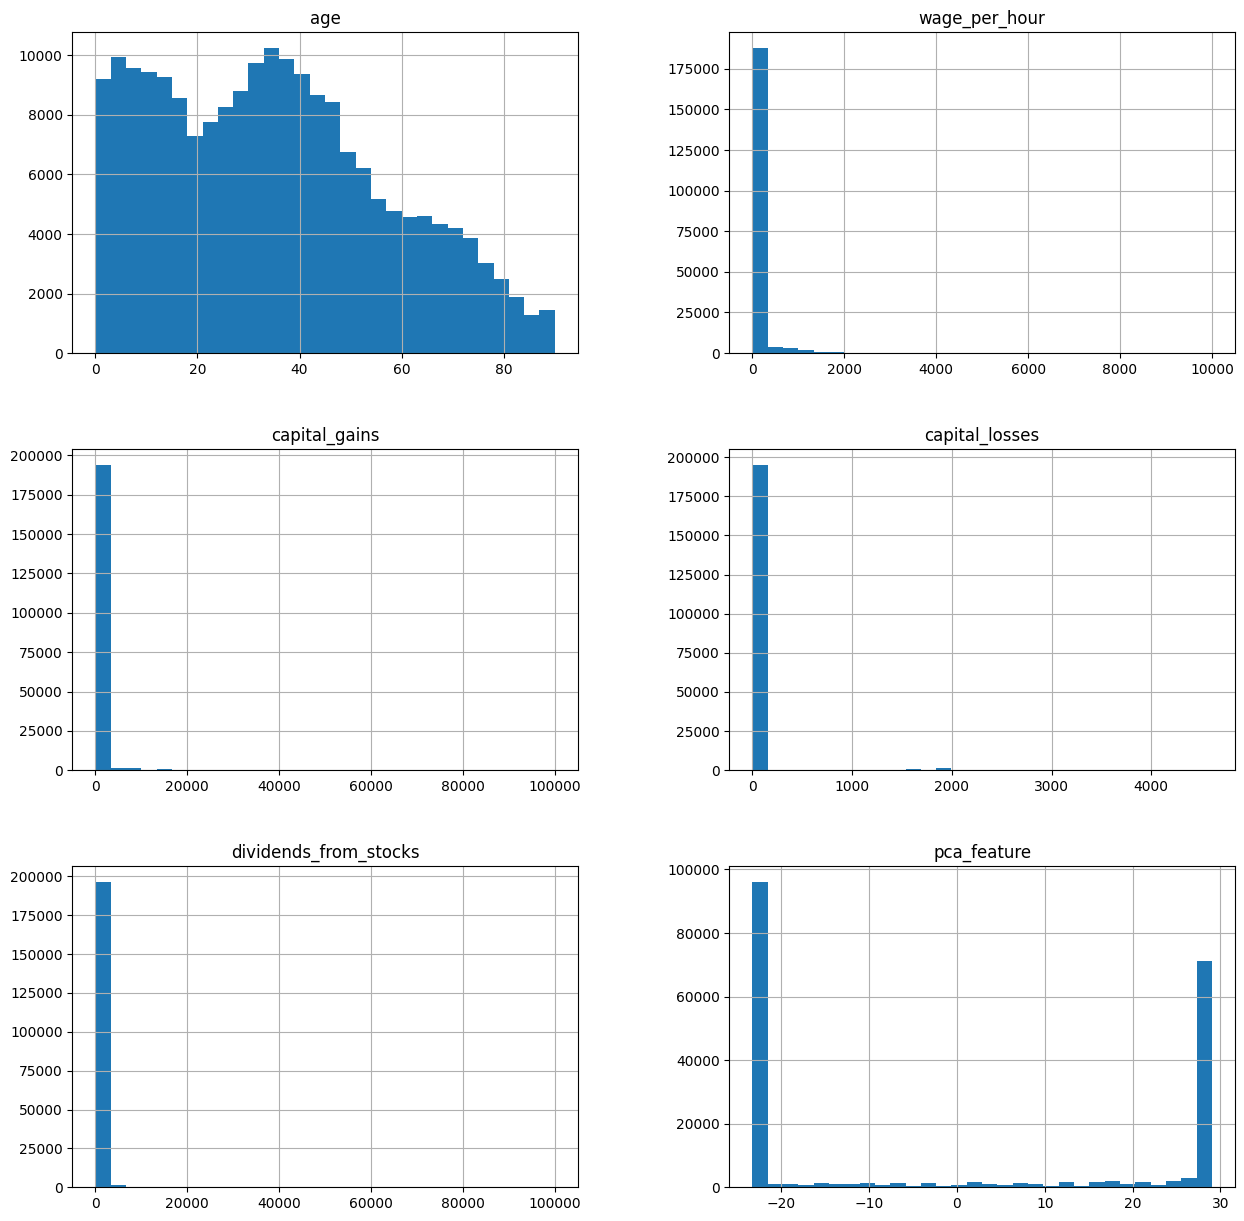

In [34]:
train[number_columns].hist(figsize = (15, 15), bins=30);

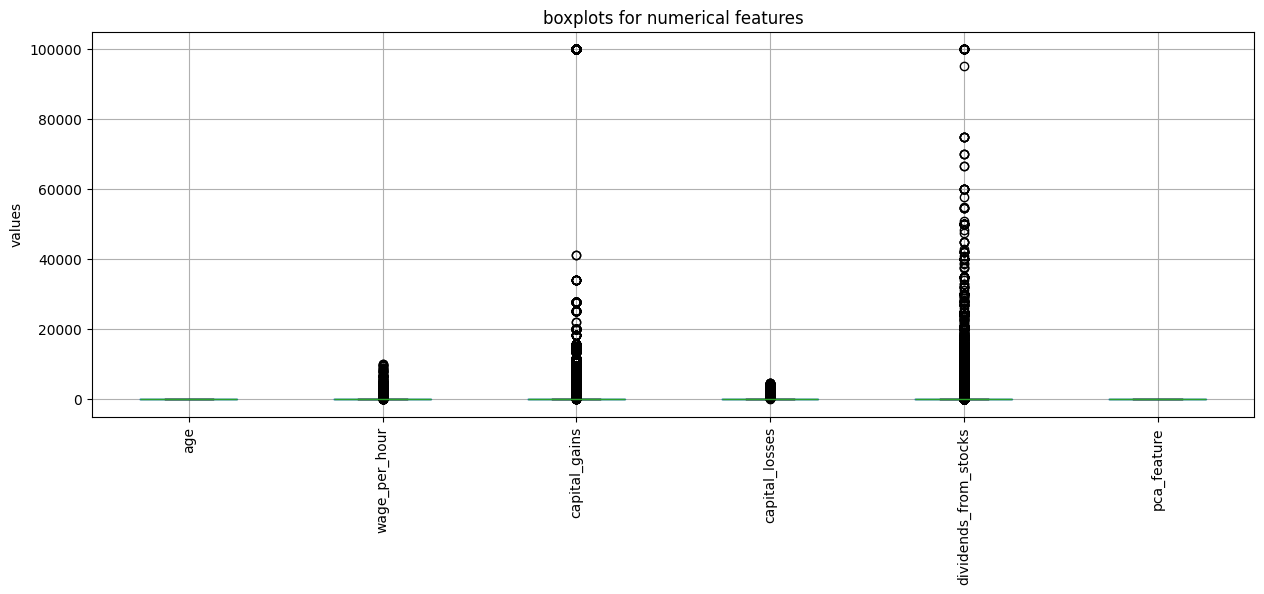

In [35]:
train[number_columns].boxplot(figsize = (15, 5), ylabel='values', rot=90)
plt.title('boxplots for numerical features');

In [36]:
outlier_columns = ['wage_per_hour', 'capital_gains', 'capital_losses', 'dividends_from_stocks']
train[outlier_columns].describe()

wage_per_hour  capital_gains  capital_losses  dividends_from_stocks
count  199144.000000  199144.000000   199144.000000          199144.000000
mean       55.532394     435.546323       37.384802             197.896422
std       275.147270    4701.960902      272.150158            1986.031651
min         0.000000       0.000000        0.000000               0.000000
25%         0.000000       0.000000        0.000000               0.000000
50%         0.000000       0.000000        0.000000               0.000000
75%         0.000000       0.000000        0.000000               0.000000
max      9999.000000   99999.000000     4608.000000           99999.000000

In [37]:
for column in outlier_columns:
    display(train[column].value_counts() / train.shape[0] * 100)

wage_per_hour
0       94.323705
500      0.368578
600      0.274173
700      0.268148
800      0.254590
          ...    
1199     0.000502
8600     0.000502
1862     0.000502
2299     0.000502
1092     0.000502
Name: count, Length: 1240, dtype: float64

capital_gains
0        96.294641
15024     0.395694
7688      0.305809
7298      0.292251
99999     0.195838
           ...    
4594      0.000502
2601      0.000502
1140      0.000502
2227      0.000502
8530      0.000502
Name: count, Length: 132, dtype: float64

capital_losses
0       98.038605
1902     0.204375
1977     0.191319
1887     0.182782
1602     0.096915
          ...    
2201     0.001004
2519     0.000502
1911     0.000502
2080     0.000502
155      0.000502
Name: count, Length: 113, dtype: float64

dividends_from_stocks
0        89.385570
100       0.576467
500       0.517214
1000      0.448921
200       0.434861
           ...    
2746      0.000502
116       0.000502
12173     0.000502
3896      0.000502
7958      0.000502
Name: count, Length: 1478, dtype: float64

We have four features with outliers: `'wage per hour'`, `'capital gains'`, `'capital losses'`, `'dividends from stocks'`. In case of `'capital gains'` and `'dividends from stocks'` the outliers are noticeably outstanding. We also can see that these features have madian equal to 0 and take only 0 values for up to 89-98% of instances.

We shall not apply any treatment to outliers now. Instead we'll perform feature selection and anomaly detection after distribution anlysis of categorical features.

#### Distribution of categorical features

In [38]:
import warnings
warnings.filterwarnings('ignore')

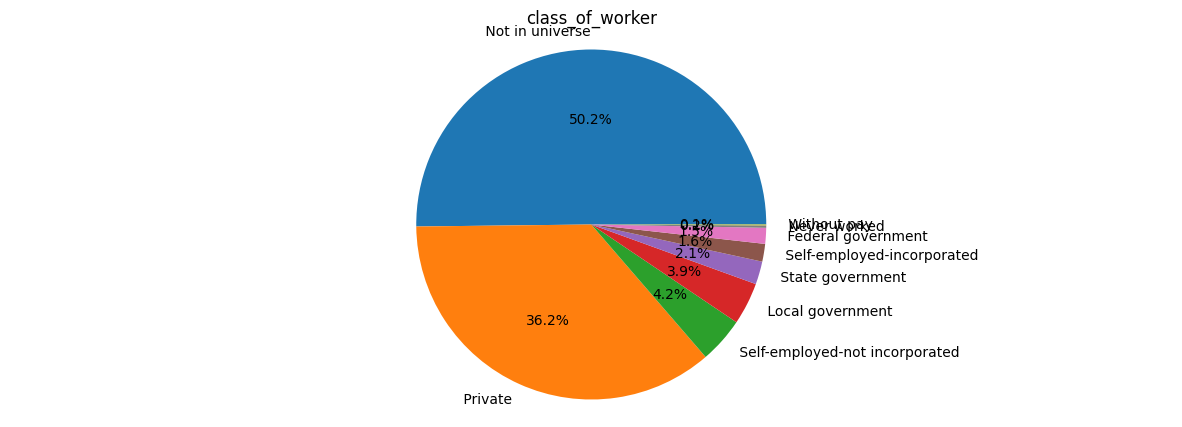

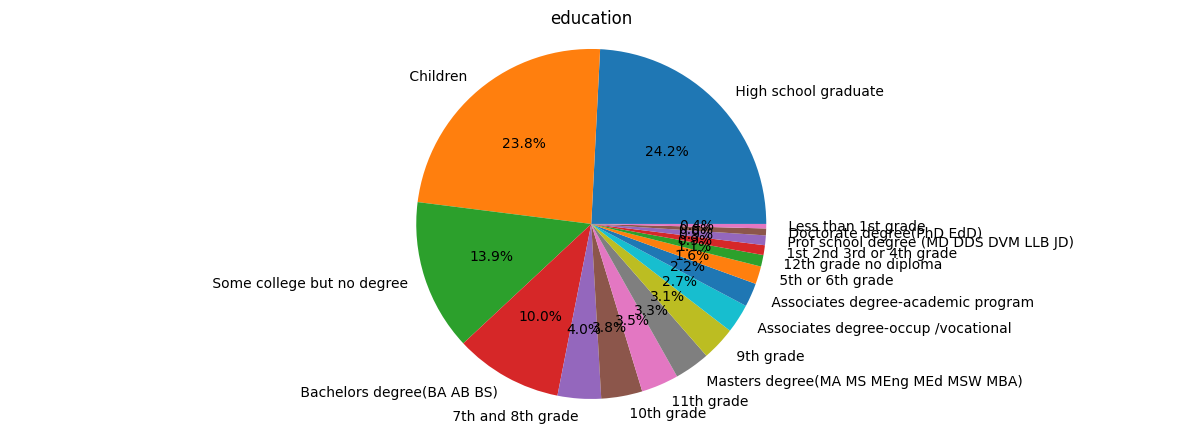

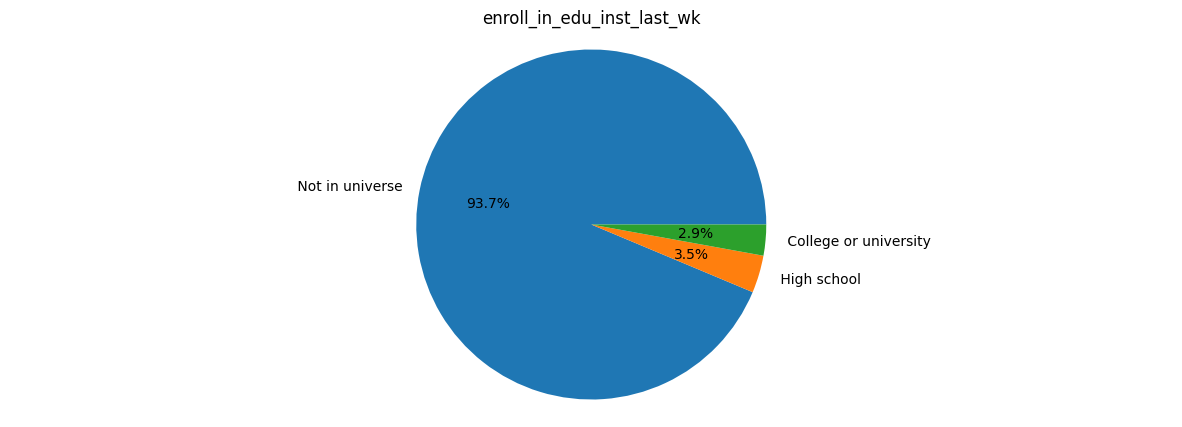

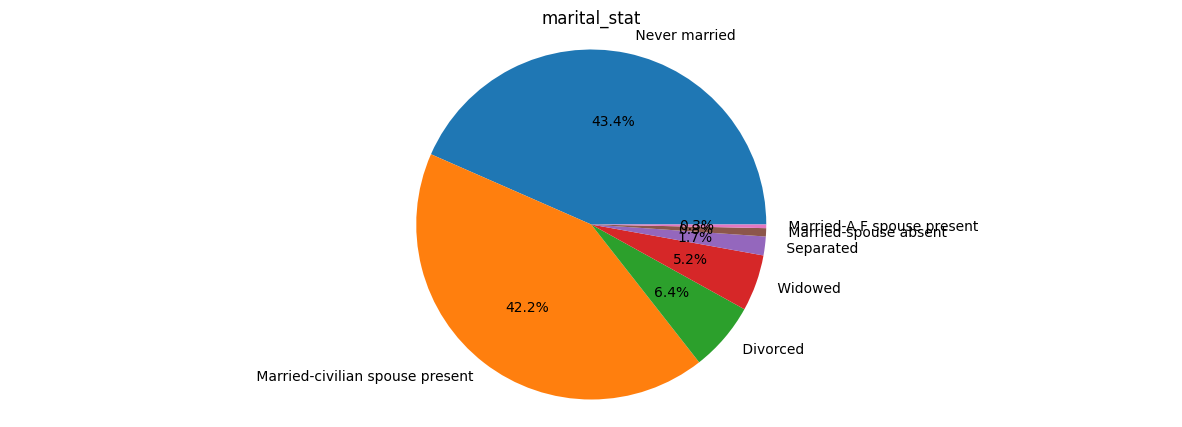

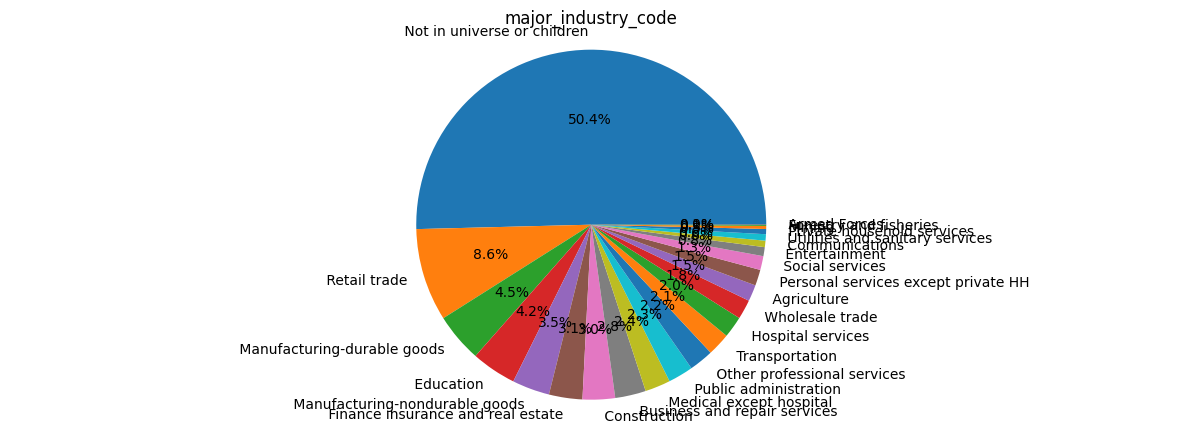

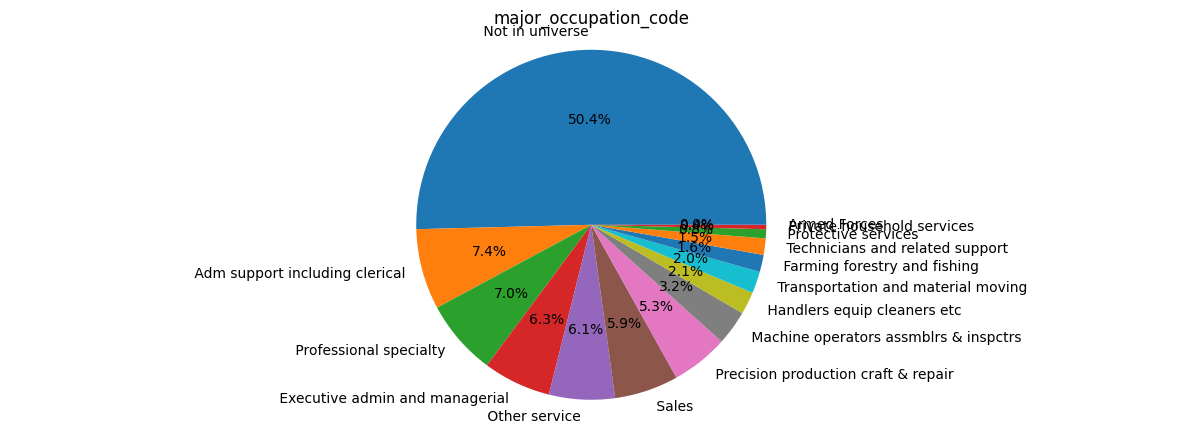

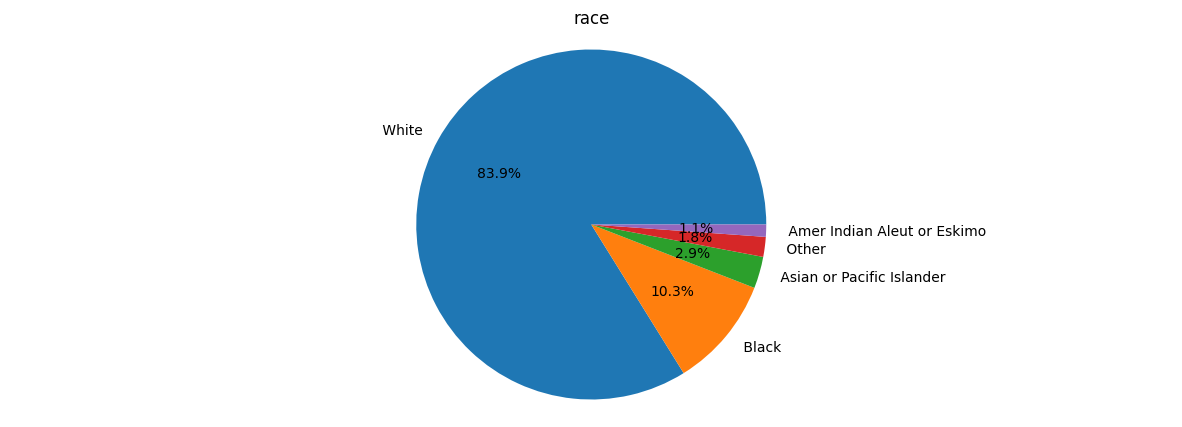

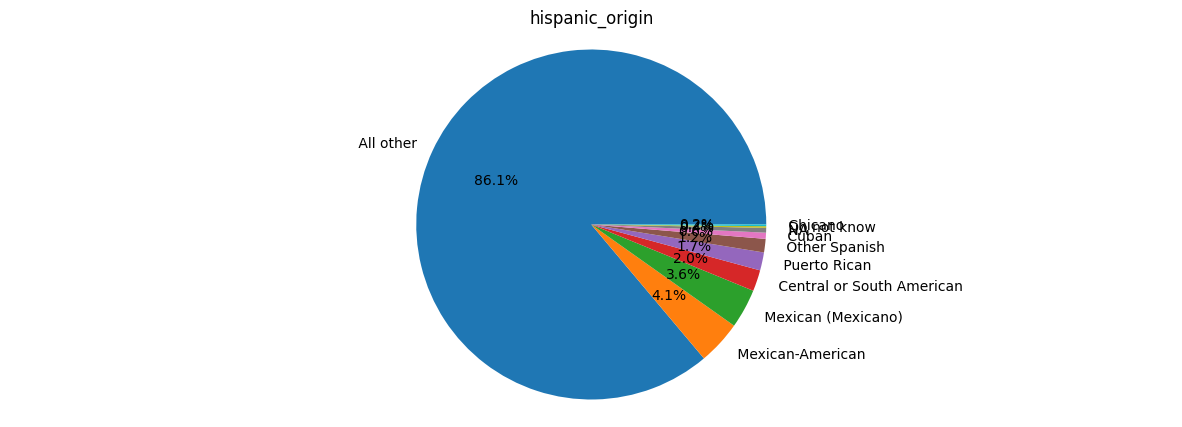

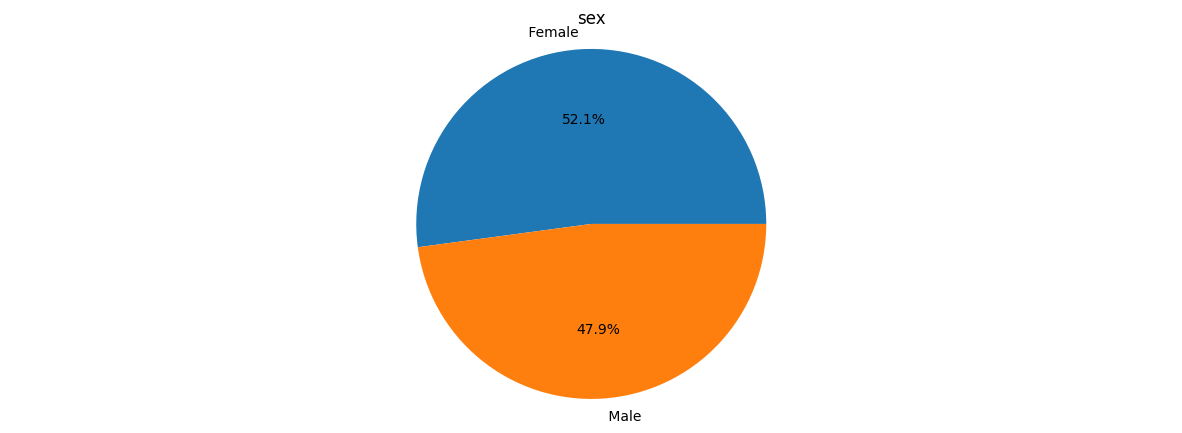

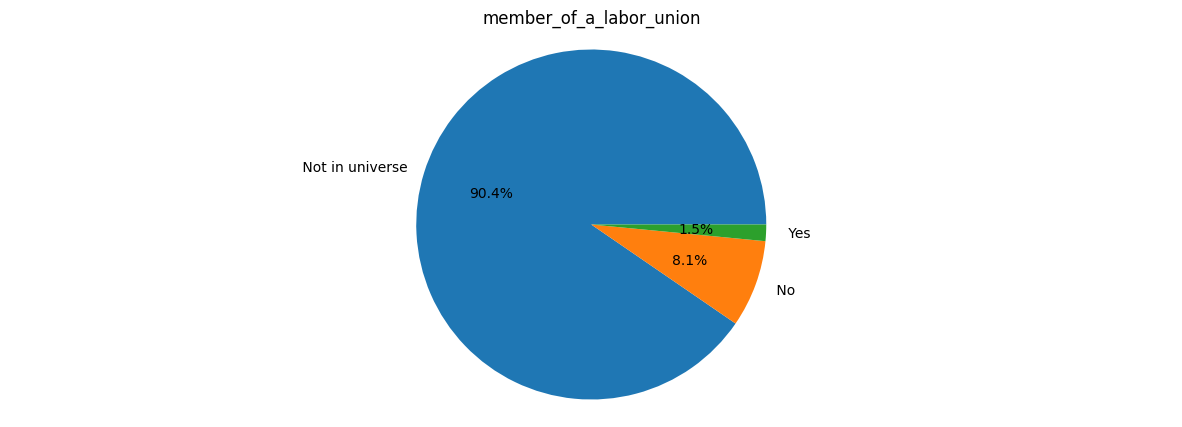

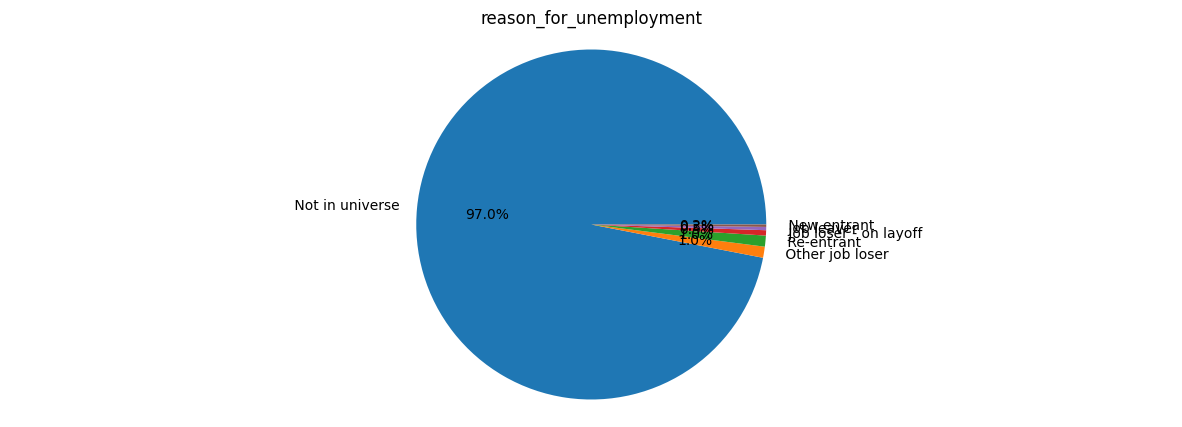

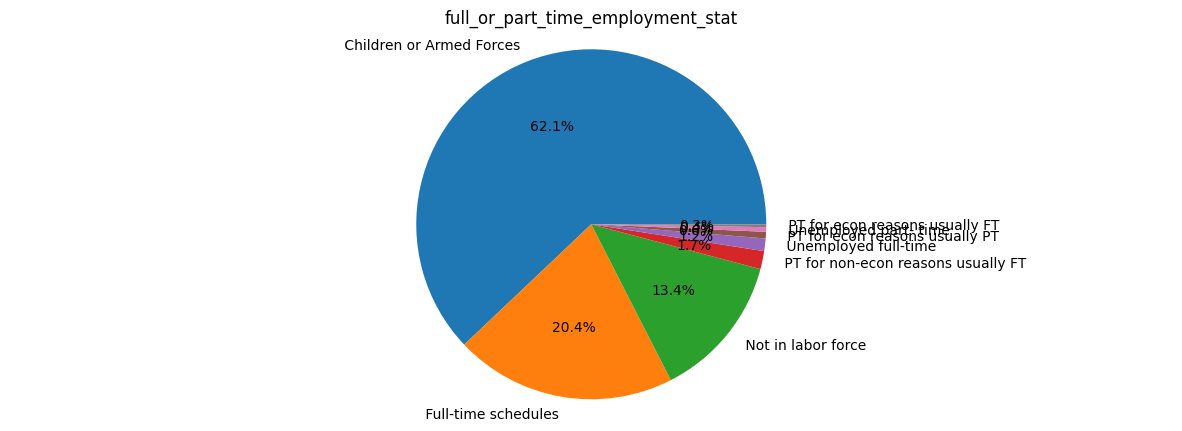

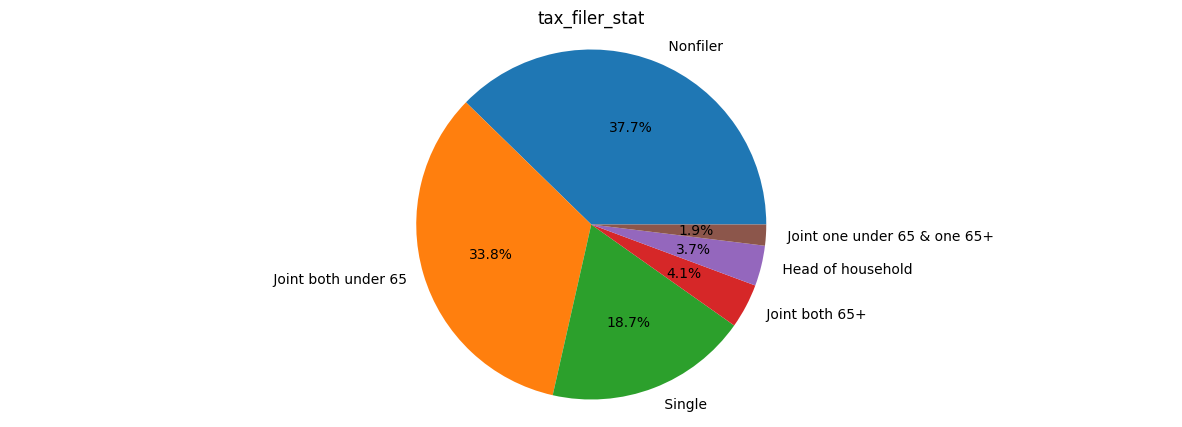

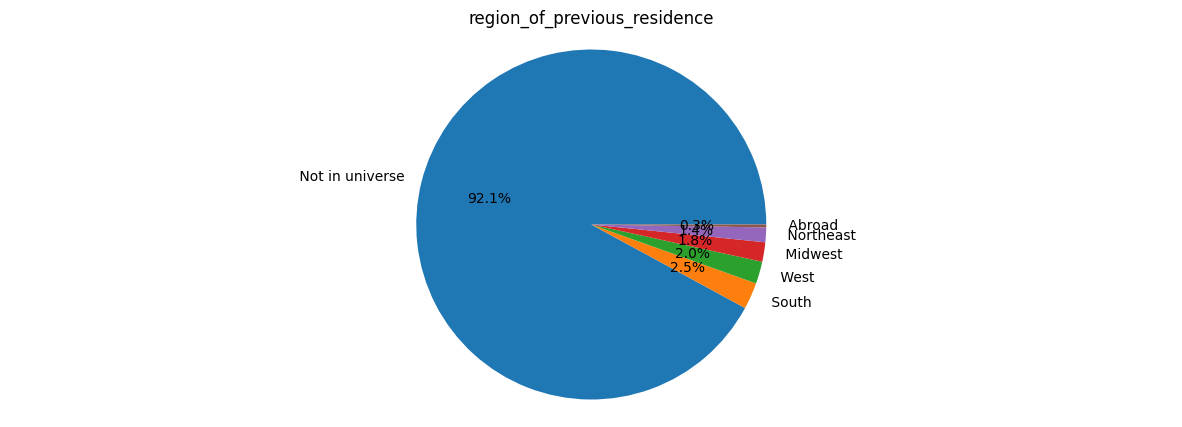

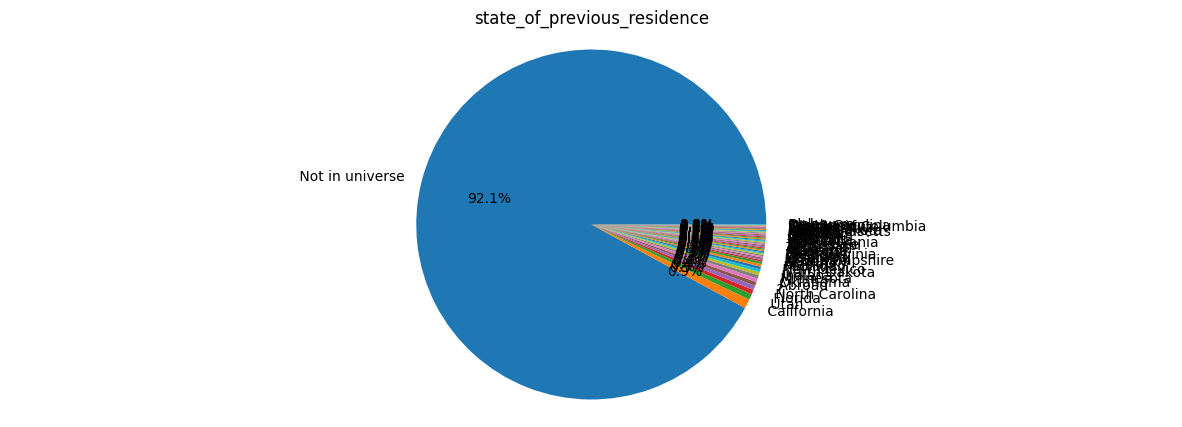

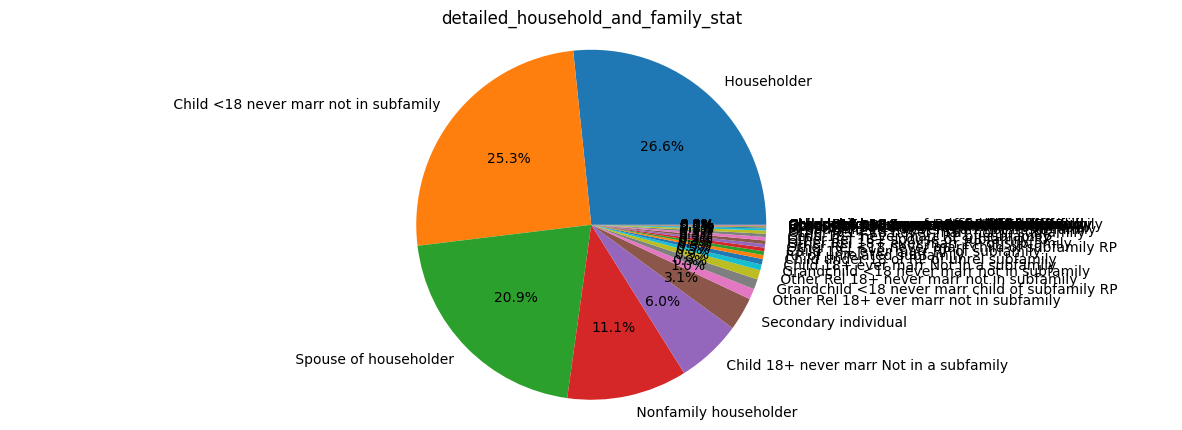

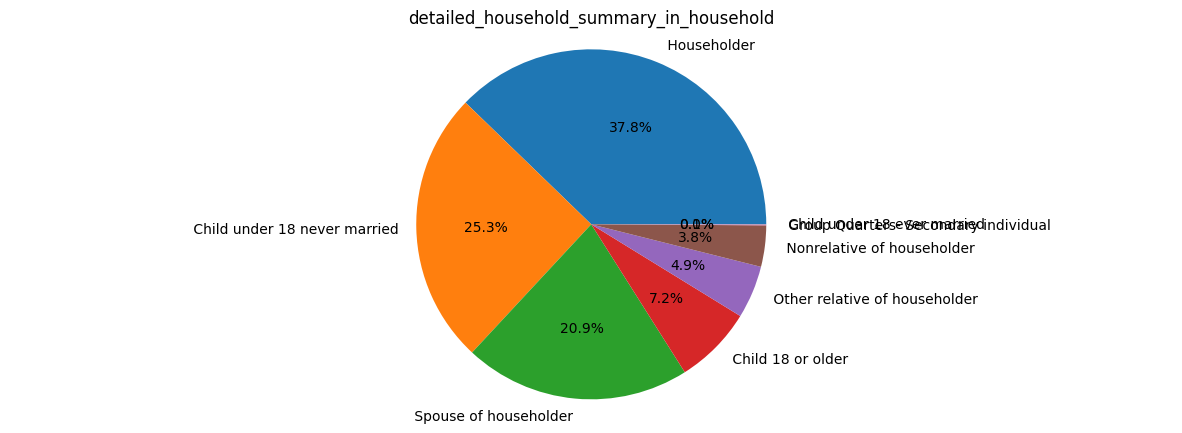

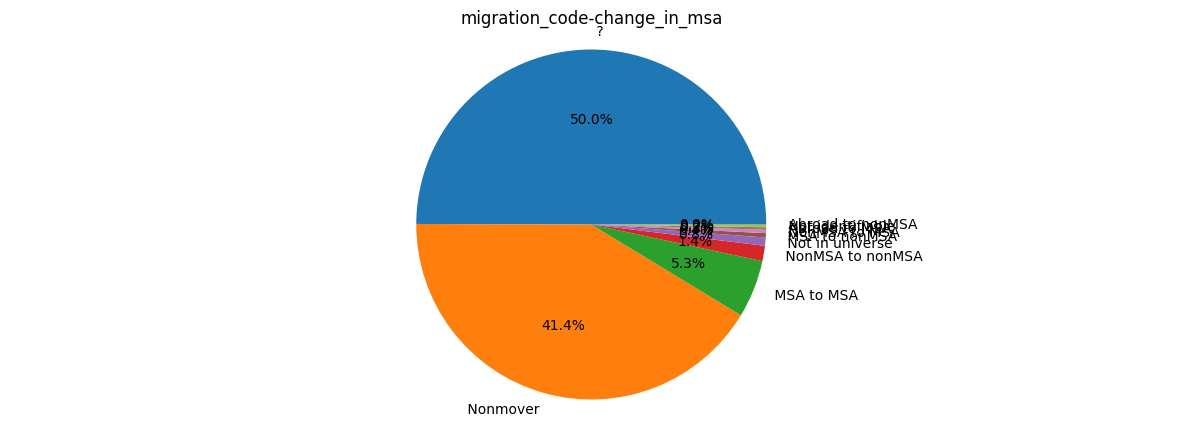

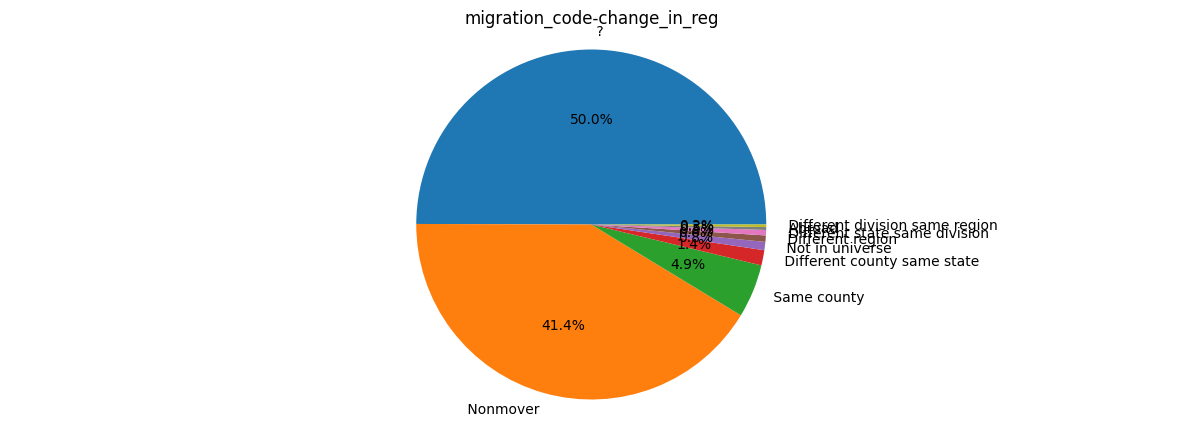

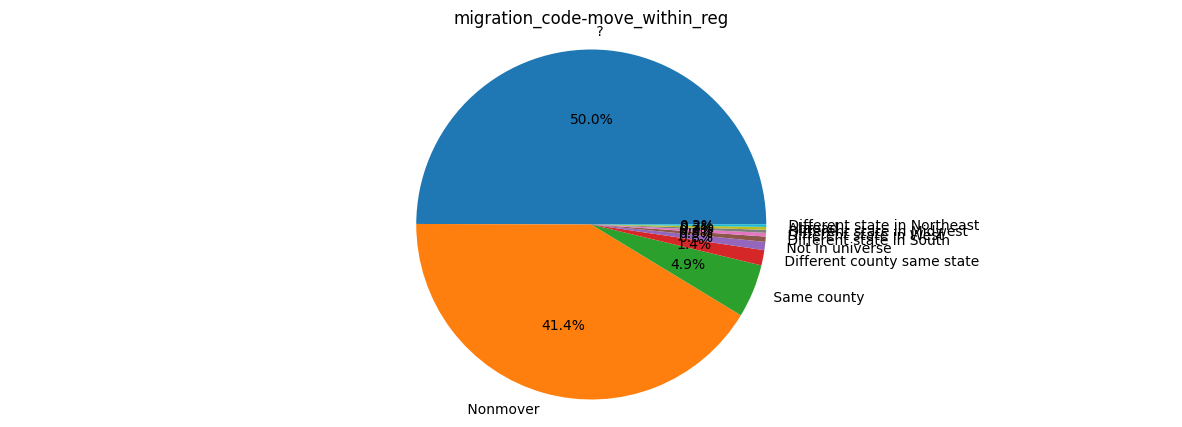

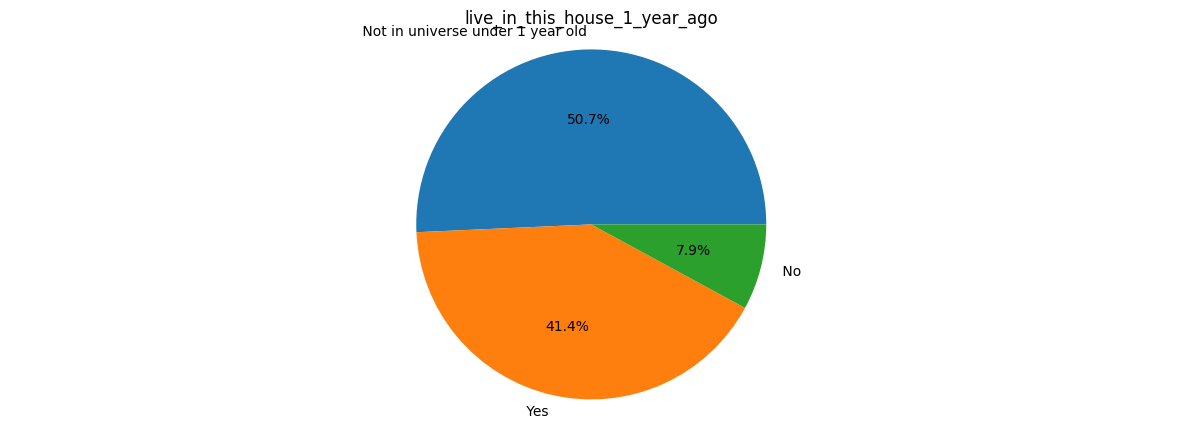

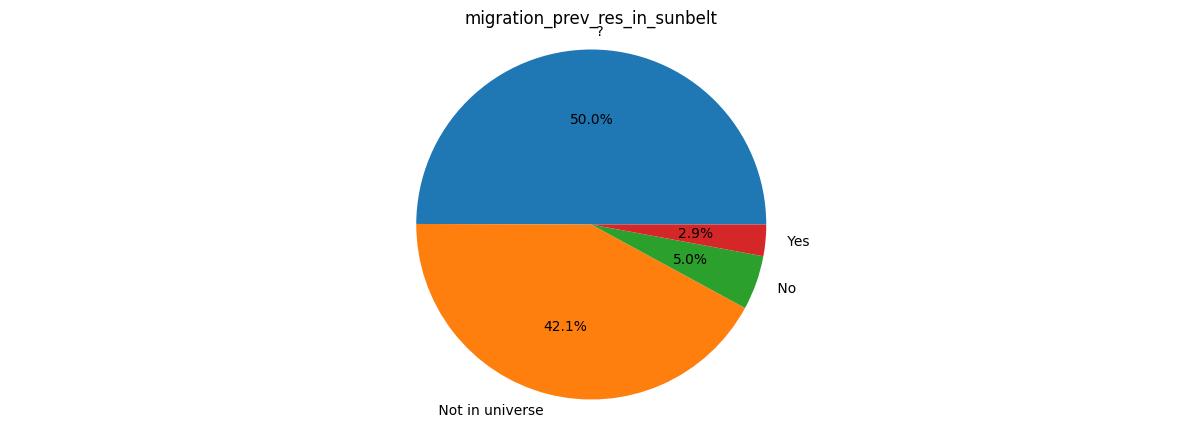

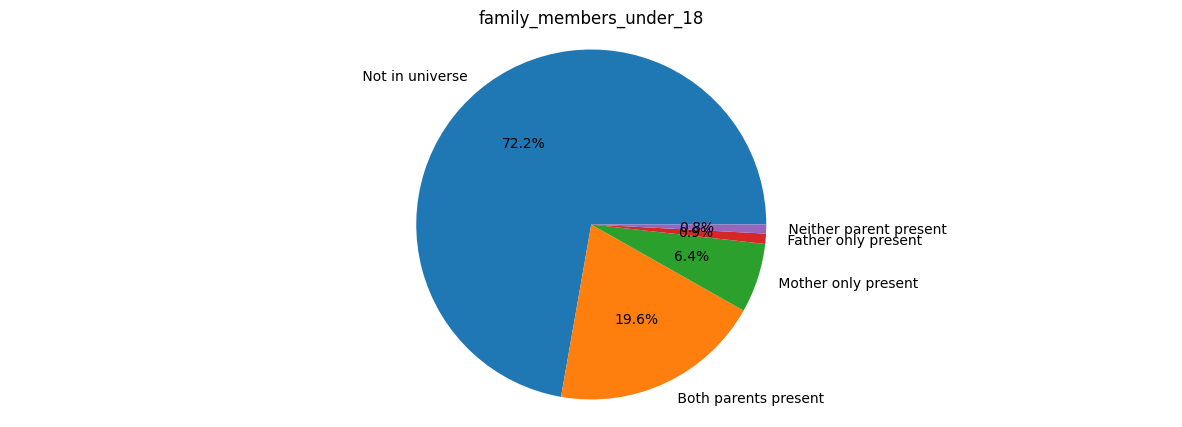

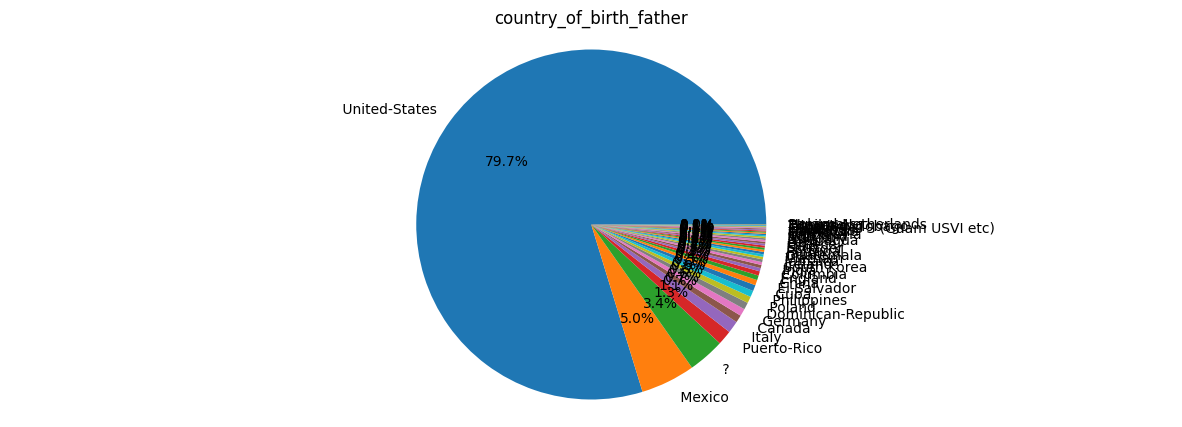

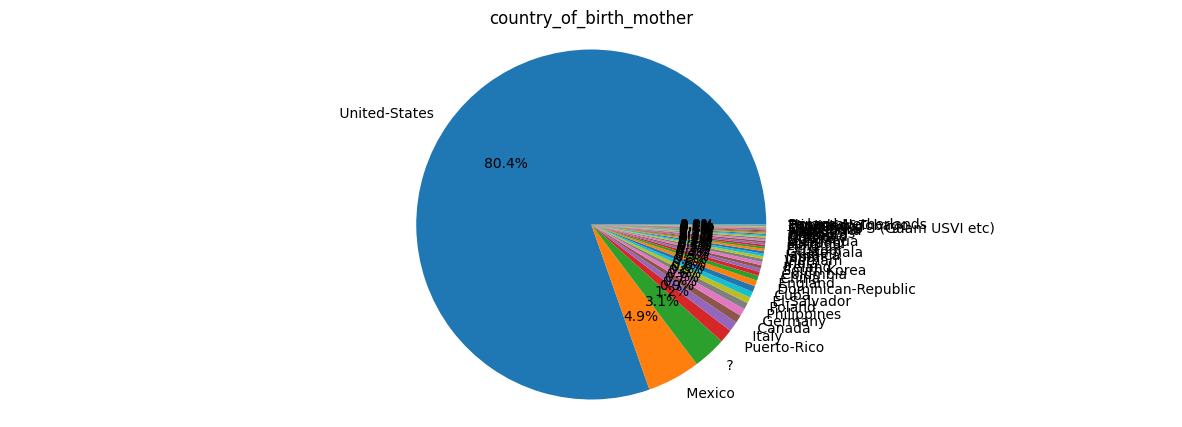

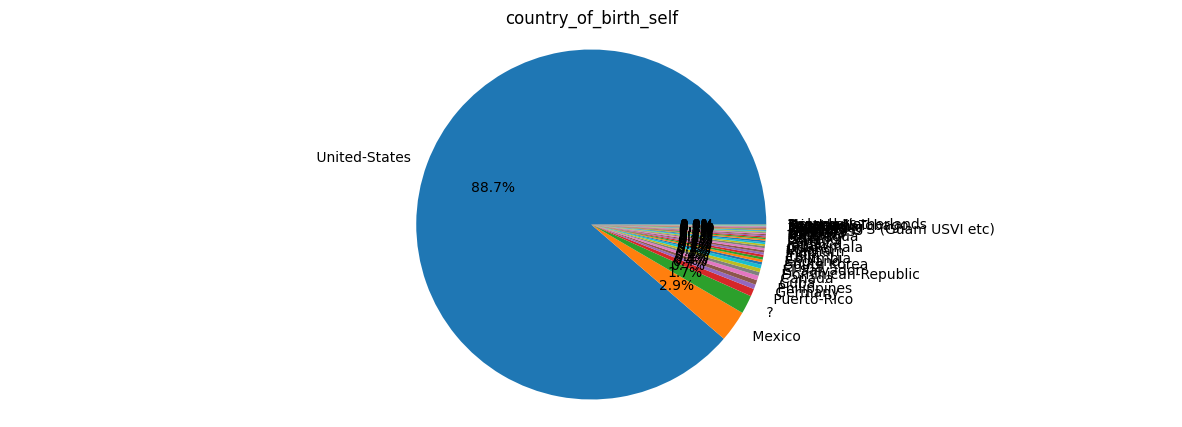

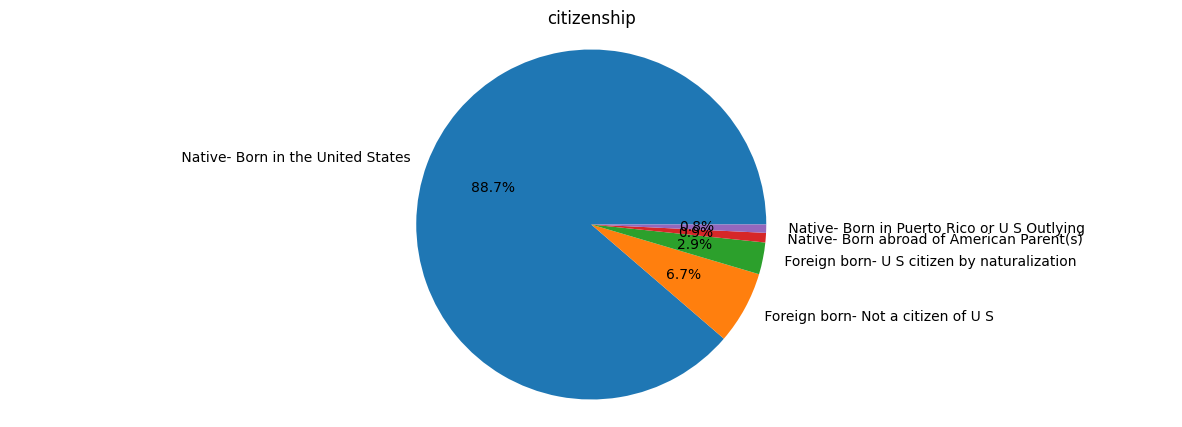

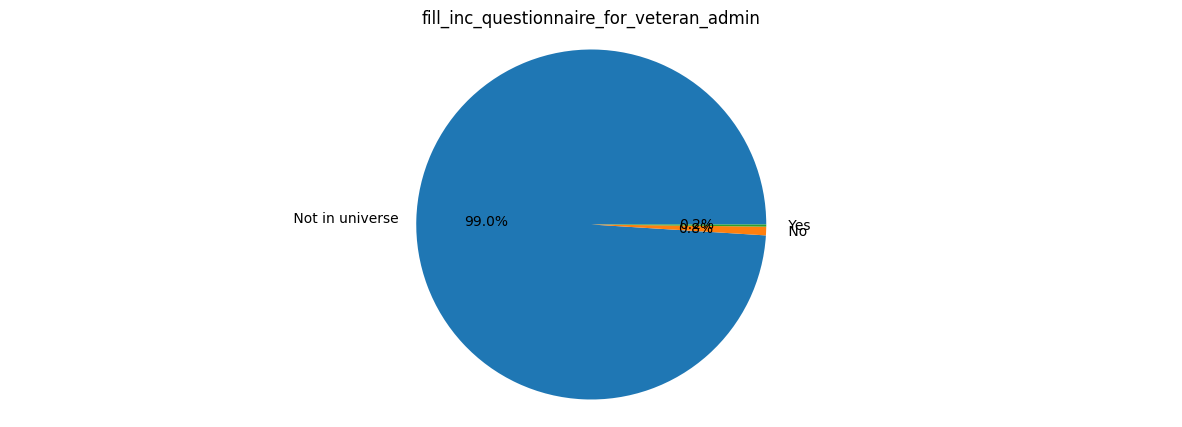

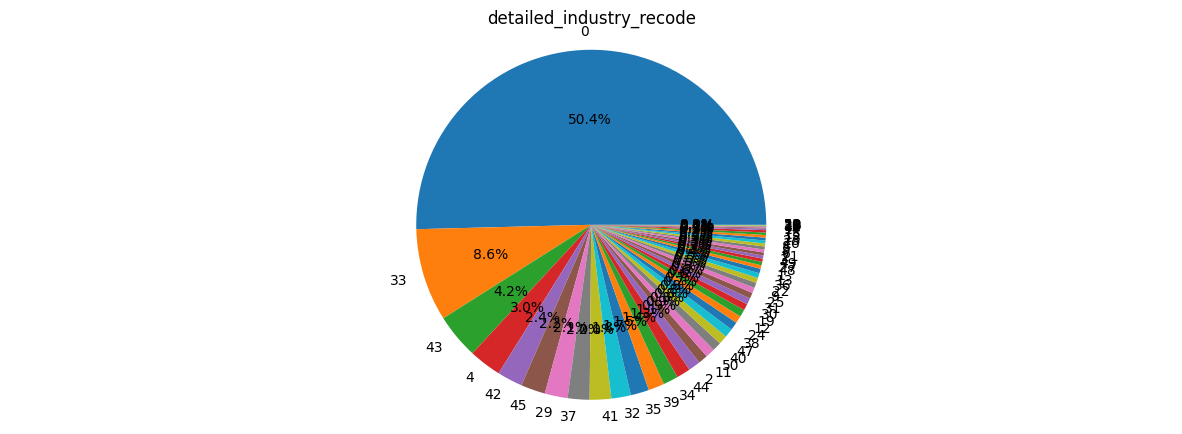

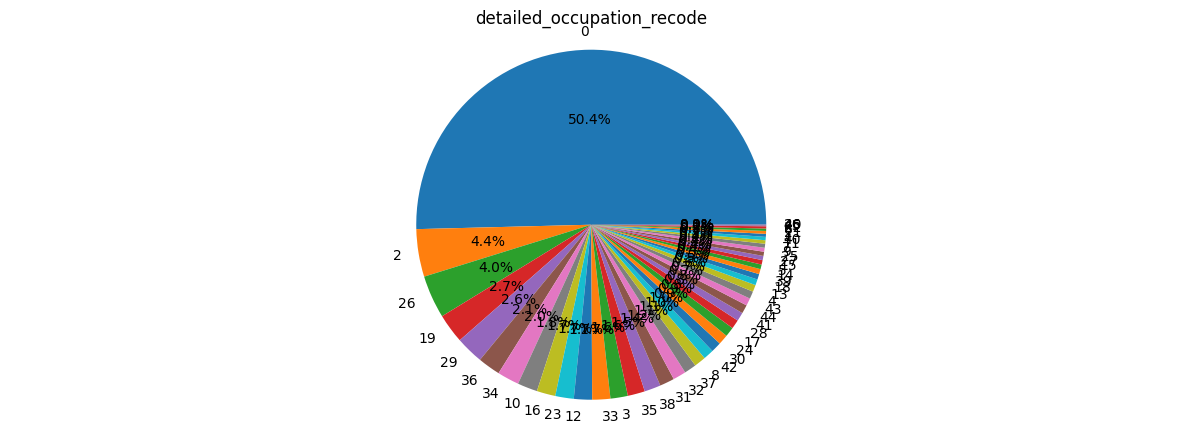

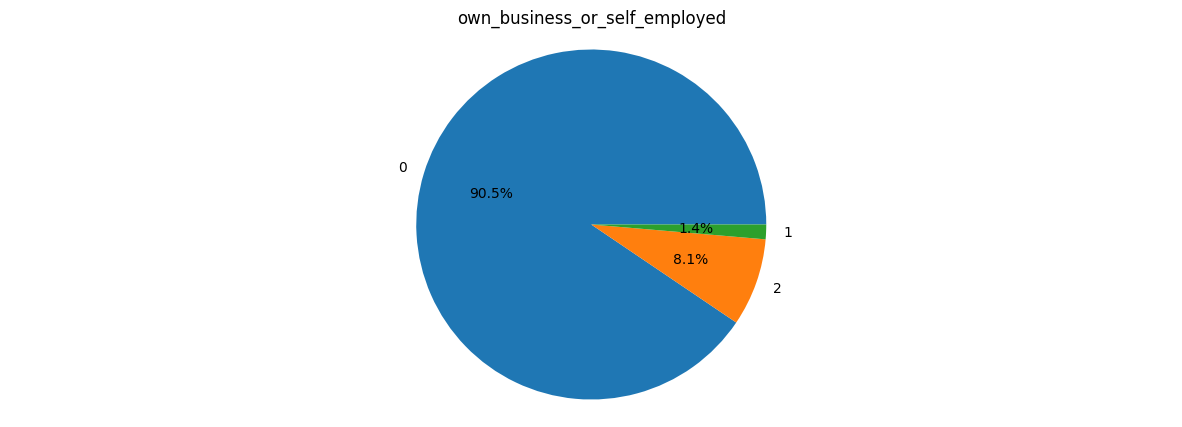

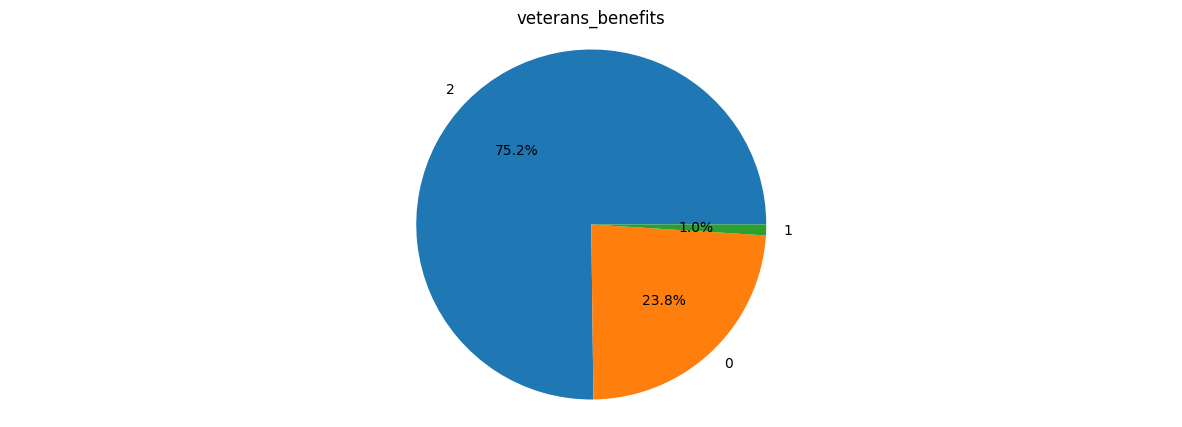

In [39]:
for column in object_columns:
    plt.figure(figsize=(15, 5))
    train[column].value_counts().plot.pie(autopct='%1.1f%%')
    plt.axis('equal')
    plt.xlabel('')
    plt.ylabel('')
    plt.title(column)
    plt.show()

It can be seen that there are two frequently occuring values: `'Not in universe'` and its derivastives, and `'?'`. We may guess that the former one denotes observations not falling into some given preset of options and the latter one denotes missing values.

There are a few outstanding features for which uninterpretable `'Not in universe'`-like values take more that 89%. These are: `'enroll in edu inst last wk'`, `'member of a labor union'`, `'reason for unemployment'`, `'region of previous residence'`, `'state of previous residence'`, `'country of birth self'`, `'fill inc questionnaire for veteran admin'`.

Let us first do anomaly detection and then apply feature selection with an assumption that outlier columns and columns with mostly `'Not in universe'`-like values are not important for our classification task, therefor our target number of features will be 27 (= 38 - 4 - 7).

In [40]:
not_iu_columns = ['enroll in edu inst last wk', 'member of a labor union', 'reason for unemployment',
                  'region of previous residence', 'state of previous residence', 'country of birth self',
                  'fill inc questionnaire for veteran admin']

In [41]:
len(number_columns), len(object_columns), len(outlier_columns), len(not_iu_columns)

(6, 32, 4, 7)

In [42]:
target_feature_number = (len(number_columns) + len(object_columns)) - (len(outlier_columns) + len(not_iu_columns))
target_feature_number

27

##### Anomaly detection

Anomaly dectection is a specific task, performing of which for imbalanced data may be particularly useful. Out of such approcahes as kNN, LOF (Local Outlier Factor) and Isolation Forest let's experiment with the latter one and preliminary WoE (Weight of Evidence) target encoding for categorical columns.

In [43]:
def woe_encoding(dataframe: pd.DataFrame, target_column=target_column):
    target = dataframe[target_column]
    encoded_dataframe = WOEEncoder(verbose=3).fit_transform(dataframe, target)
    return encoded_dataframe

In [44]:
def anomaly_drop(dataframe: pd.DataFrame, contamination=0.01):
    model = IsolationForest(contamination=contamination)
    encoded_dataframe = woe_encoding(dataframe)
    model.fit(encoded_dataframe)
    dataframe = dataframe[pd.Series(model.predict(encoded_dataframe), index=dataframe.index) != -1]
    return dataframe

Removing anomalies from train and test data.

In [45]:
shape_before = train.shape[0]
train = anomaly_drop(train)
shape_after = train.shape[0]
print('TRAIN data')
print(f'Shape before:\t{shape_before}, \
       \nShape after:\t{shape_after}, \
       \nAnomalies removed: {shape_before - shape_after}')

TRAIN data
Shape before:	199144,        
Shape after:	197152,        
Anomalies removed: 1992


In [46]:
shape_before = test.shape[0]
test = anomaly_drop(test)
shape_after = test.shape[0]
print('TEST data')
print(f'Shape before:\t{shape_before}, \
       \nShape after:\t{shape_after}, \
       \nAnomalies removed: {shape_before - shape_after}')

TEST data
Shape before:	99643,        
Shape after:	98646,        
Anomalies removed: 997


##### Feature selection

Leat us experiment with `RFE` (Recursive feature Elimitaion), which is an iterative feature selection technique that recursively removes less important features until the desired number of features is reached. For this purpose we shall apply `RandomForestClassifier` with `class_weight='balanced'`, which is a more suitable choice for feature selection from an imbalanced dataset with mostly categorical features.

Prior to this, categorical features will be encoded using WoE (Weight of evidence) encoder. WoE is a type of target encoders specially designed for binary classification. Further, while data preprocessing it will be used as main feature encoder.

In [47]:
def feature_selection(X: pd.DataFrame, y: pd.Series):
    model = RandomForestClassifier(class_weight='balanced')
    rfe = RFE(model, n_features_to_select=target_feature_number)
    rfe.fit_transform(X, y)
    selected_indices = rfe.get_support(indices=True)
    selected_names = X.columns[selected_indices]
    return selected_names

In [48]:
X = woe_encoding(train[number_columns + object_columns + [target_column]]).drop(target_column, axis=1)
y = train[target_column]
selected_features = feature_selection(X, y)

In [49]:
print(f'Selected {selected_features.shape[0]} features: \n\n{selected_features}')

Selected 27 features: 

Index(['age', 'wage_per_hour', 'capital_gains', 'capital_losses',
       'dividends_from_stocks', 'pca_feature', 'class_of_worker', 'education',
       'marital_stat', 'major_industry_code', 'major_occupation_code', 'race',
       'sex', 'member_of_a_labor_union', 'full_or_part_time_employment_stat',
       'tax_filer_stat', 'detailed_household_and_family_stat',
       'detailed_household_summary_in_household',
       'migration_code-change_in_msa', 'migration_code-change_in_reg',
       'migration_code-move_within_reg', 'country_of_birth_father',
       'country_of_birth_mother', 'country_of_birth_self',
       'detailed_industry_recode', 'detailed_occupation_recode',
       'own_business_or_self_employed'],
      dtype='object')


In [50]:
removed_features = [feature for feature in all_columns if feature not in selected_features]
removed_unexpected_features = [feature for feature in removed_features
                               if feature not in outlier_columns and feature not in not_iu_columns]
removed_outliers = [feature for feature in removed_features if feature in outlier_columns]
removed_categorical = [feature for feature in removed_features if feature in not_iu_columns]

print(f'Out of {len(outlier_columns)} outlier columns: {outlier_columns} \
      \n>>> removed {len(removed_outliers)}: {removed_outliers}\n')
print(f'Out of {len(not_iu_columns)} `not in universe` columns: {not_iu_columns} \
      \n>>> removed {len(removed_categorical)}: {removed_categorical}\n')
print(f'Columns we did not consider for removal: \
      \n>>> {len(removed_unexpected_features)} features: {removed_unexpected_features}')

Out of 4 outlier columns: ['wage_per_hour', 'capital_gains', 'capital_losses', 'dividends_from_stocks']       
>>> removed 0: []

Out of 7 `not in universe` columns: ['enroll in edu inst last wk', 'member of a labor union', 'reason for unemployment', 'region of previous residence', 'state of previous residence', 'country of birth self', 'fill inc questionnaire for veteran admin']       
>>> removed 0: []

Columns we did not consider for removal:       
>>> 11 features: ['enroll_in_edu_inst_last_wk', 'hispanic_origin', 'reason_for_unemployment', 'region_of_previous_residence', 'state_of_previous_residence', 'live_in_this_house_1_year_ago', 'migration_prev_res_in_sunbelt', 'family_members_under_18', 'citizenship', 'fill_inc_questionnaire_for_veteran_admin', 'veterans_benefits']


### [25%] 2. Data preprocessing

* 2.1. (8%) Fill missing values (if there are any)
* 2.2. (9%) Properly encode categorical features. Explain your choice of methods of categorical feature encoding
* 2.3. (8%) Cluster observations and add cluster number as one of the features. Make sure that the clustering method has a good quality



##### 2.1. Missing values

As pointed out before, there are no missing values in the dataset. We have made a guess that missing values were encoded with `'?'`.

In [51]:
train.isna().sum().sum(), test.isna().sum().sum()

(0, 0)

In [52]:
train, test = train[np.append(selected_features, target_column)], test[np.append(selected_features, target_column)]

##### 2.2. Fature encoding

We shall use ordinal encoding to avoid dimensionality increase resulting from OHE (One Hot Encoding) and target leakage potentially inferred from WoE.

In [53]:
train.head(3)

age  wage_per_hour  capital_gains  capital_losses  dividends_from_stocks  \
0   73              0              0               0                      0   
1   58              0              0               0                      0   
2   18              0              0               0                      0   

   pca_feature                  class_of_worker                    education  \
0   -23.279946                  Not in universe         High school graduate   
1    28.655722   Self-employed-not incorporated   Some college but no degree   
2   -23.279946                  Not in universe                   10th grade   

     marital_stat           major_industry_code  ...  \
0         Widowed   Not in universe or children  ...   
1        Divorced                  Construction  ...   
2   Never married   Not in universe or children  ...   

  migration_code-change_in_msa migration_code-change_in_reg  \
0                            ?                            ?   
1                   MSA to MSA                  Same county   
2                            ?                            ?   

  migration_code-move_within_reg country_of_birth_father  \
0                              ?           United-States   
1                    Same county           United-States   
2                              ?                 Vietnam   

  country_of_birth_mother country_of_birth_self detailed_industry_recode  \
0           United-States         United-States                        0   
1           United-States         United-States                        4   
2                 Vietnam               Vietnam                        0   

  detailed_occupation_recode own_business_or_self_employed target  
0                          0                             0      0  
1                         34                             0      0  
2                          0                             0      0  

[3 rows x 28 columns]

In [54]:
columns_to_encode = train.select_dtypes(include='object').columns
encoder = OrdinalEncoder()

In [55]:
# train, test = woe_encoding(train), woe_encoding(test)
train[columns_to_encode] = encoder.fit_transform(train[columns_to_encode])
test[columns_to_encode] = encoder.fit_transform(test[columns_to_encode])

In [56]:
train.head(3)

age  wage_per_hour  capital_gains  capital_losses  dividends_from_stocks  \
0   73              0              0               0                      0   
1   58              0              0               0                      0   
2   18              0              0               0                      0   

   pca_feature  class_of_worker  education  marital_stat  major_industry_code  \
0   -23.279946              3.0       12.0           6.0                 14.0   
1    28.655722              6.0       16.0           0.0                  4.0   
2   -23.279946              3.0        0.0           4.0                 14.0   

   ...  migration_code-change_in_msa  migration_code-change_in_reg  \
0  ...                           0.0                           0.0   
1  ...                           3.0                           8.0   
2  ...                           0.0                           0.0   

   migration_code-move_within_reg  country_of_birth_father  \
0                             0.0                     40.0   
1                             9.0                     40.0   
2                             0.0                     41.0   

   country_of_birth_mother  country_of_birth_self  detailed_industry_recode  \
0                     40.0                   40.0                         0   
1                     40.0                   40.0                         4   
2                     41.0                   41.0                         0   

   detailed_occupation_recode  own_business_or_self_employed  target  
0                           0                              0       0  
1                          34                              0       0  
2                           0                              0       0  

[3 rows x 28 columns]

In [57]:
y_train, y_test = train[target_column], test[target_column]
X_train, X_test = train.drop(target_column, axis=1), test.drop(target_column, axis=1)

##### 2.3. Clusterization

Let us perform clasterization using HDBSCAN, which unlike kNN does not require presetting the number of clusters and unlike DBSCAN finds clusters of varying densities.

In [58]:
# this code for GPU computing requires proper preimports

# hdbscan_model = hdbscan.HDBSCAN(prediction_data=True, verbose=3)
# cluster_label = 'cluster_label'
# clusterer = hdbscan_model.fit(X_train)

# X_train[cluster_label] = clusterer.labels_
# X_test[cluster_label] = hdbscan.approximate_predict(clusterer, X_test)[0]


cluster_label = 'cluster_label'
hdbscan_model = HDBSCAN(n_jobs=-1)
X_train[cluster_label] = hdbscan_model.fit_predict(X_train)
X_test[cluster_label] = hdbscan_model.fit_predict(X_test)

### [25%] 3. Model training

* 3.1. (8%) Apply different techniques which can help to work with imbalanced data. You are supposed to try at least 2 techniques (in the end, you don't have to include them into your final pipeline - but you should explain why)
* 3.2. (9%) Train different machine learning models, including the advanced boosting algorithms studied during the course. Carefully tune hyperparameters of the algorithms. You are supposed to compare at least 3 models
* 3.3. (8%) Perform blending or stacking of the trained machine learning algorithms. Carefully tune the weights of the ensemble



##### 3.1. Techniques helping to work with imbalanced data

We shall apply a combination of oversampling and undersampling techniques:
* we oversample the minority class using SMOTE to create synthetic examples,
* then, we undersample the majority class using Tomek Links to remove instances from the majority class that are close to the minority class.

Additionally, we'll use an algorithmic technique by setting argument `class_weight='balanced'` while training one of our models.

In [59]:
X_sampled, y_sampled = SMOTETomek(sampling_strategy=0.8, n_jobs=-1).fit_resample(X_train, y_train)

#### 3.2. Model training

Let us train the following models, which are suitable for classification tasks:
* LightGBM Classifier
* CatBoost Classifier
* RandomRorest Classifier

In [60]:
random_state=100

model_lgbm = LGBMClassifier(random_state=random_state, n_jobs=-1)
model_catb = CatBoostClassifier(random_state=random_state, verbose=3)
model_rndf = RandomForestClassifier(class_weight='balanced', random_state=random_state, verbose=3, n_jobs=-1)

params_lgbm = {
    'num_leaves': [62, 124],
    'learning_rate': [0.2, 0.5],
}

params_catb = {
    'iterations': [300, 500],
    'learning_rate': [0.2, 0.5],
}

params_rndf = {
    'n_estimators': [150, 300],
    'max_depth': [None, 50],
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)

grid_lgbm = GridSearchCV(model_lgbm, params_lgbm, cv=cv, scoring='balanced_accuracy', verbose=3, n_jobs=-1).fit(X_sampled, y_sampled)
grid_catb = GridSearchCV(model_catb, params_catb, cv=cv, scoring='balanced_accuracy', verbose=3, n_jobs=-1).fit(X_sampled, y_sampled)
grid_rndf = GridSearchCV(model_rndf, params_rndf, cv=cv, scoring='balanced_accuracy', verbose=3, n_jobs=-1).fit(X_sampled, y_sampled)



Fitting 5 folds for each of 4 candidates, totalling 20 fits
[LightGBM] [Info] Number of positive: 147429, number of negative: 184425
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.018831 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6285
[LightGBM] [Info] Number of data points in the train set: 331854, number of used features: 28
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.444259 -> initscore=-0.223896
[LightGBM] [Info] Start training from score -0.223896
Fitting 5 folds for each of 4 candidates, totalling 20 fits
0:	learn: 0.4645827	total: 165ms	remaining: 1m 22s
3:	learn: 0.2960819	total: 241ms	remaining: 29.9s
6:	learn: 0.2214652	total: 313ms	remaining: 22s
9:	learn: 0.1821401	total: 389ms	remaining: 19.1s
12:	learn: 0.1664876	total: 469ms	remaining: 17.6s
15:	learn: 0.1547847	total: 543ms	remaining: 16.4s
18:	learn: 0.14779

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.


building tree 1 of 300
building tree 2 of 300
building tree 3 of 300
building tree 4 of 300
building tree 5 of 300
building tree 6 of 300
building tree 7 of 300
building tree 8 of 300
building tree 9 of 300
building tree 10 of 300
building tree 11 of 300
building tree 12 of 300
building tree 13 of 300
building tree 14 of 300
building tree 15 of 300
building tree 16 of 300
building tree 17 of 300
building tree 18 of 300
building tree 19 of 300
building tree 20 of 300
building tree 21 of 300
building tree 22 of 300
building tree 23 of 300
building tree 24 of 300
building tree 25 of 300
building tree 26 of 300
building tree 27 of 300
building tree 28 of 300
building tree 29 of 300
building tree 30 of 300
building tree 31 of 300
building tree 32 of 300
building tree 33 of 300
building tree 34 of 300
building tree 35 of 300
building tree 36 of 300
building tree 37 of 300
building tree 38 of 300
building tree 39 of 300
building tree 40 of 300
building tree 41 of 300
building tree 42 of 300
b

[Parallel(n_jobs=-1)]: Done  96 tasks      | elapsed:   10.8s


building tree 116 of 300
building tree 117 of 300
building tree 118 of 300
building tree 119 of 300
building tree 120 of 300
building tree 121 of 300
building tree 122 of 300
building tree 123 of 300
building tree 124 of 300
building tree 125 of 300
building tree 126 of 300
building tree 127 of 300
building tree 128 of 300
building tree 129 of 300
building tree 130 of 300
building tree 131 of 300
building tree 132 of 300
building tree 133 of 300
building tree 134 of 300
building tree 135 of 300
building tree 136 of 300
building tree 137 of 300
building tree 138 of 300
building tree 139 of 300
building tree 140 of 300
building tree 141 of 300
building tree 142 of 300
building tree 143 of 300
building tree 144 of 300
building tree 145 of 300
building tree 146 of 300
building tree 147 of 300
building tree 148 of 300
building tree 149 of 300
building tree 150 of 300
building tree 151 of 300
building tree 152 of 300
building tree 153 of 300
building tree 154 of 300
building tree 155 of 300


[Parallel(n_jobs=-1)]: Done 256 tasks      | elapsed:   26.7s


building tree 273 of 300
building tree 274 of 300
building tree 275 of 300
building tree 276 of 300
building tree 277 of 300
building tree 278 of 300
building tree 279 of 300
building tree 280 of 300
building tree 281 of 300
building tree 282 of 300
building tree 283 of 300
building tree 284 of 300
building tree 285 of 300
building tree 286 of 300
building tree 287 of 300
building tree 288 of 300
building tree 289 of 300
building tree 290 of 300
building tree 291 of 300
building tree 292 of 300
building tree 293 of 300
building tree 294 of 300
building tree 295 of 300
building tree 296 of 300
building tree 297 of 300building tree 298 of 300

building tree 299 of 300
building tree 300 of 300


[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:   31.0s finished


In [61]:
val_score_lgbm = cross_val_score(grid_lgbm.best_estimator_, X_sampled, y_sampled, cv=cv, scoring='balanced_accuracy', n_jobs=-1)
val_score_catb = cross_val_score(grid_catb.best_estimator_, X_sampled, y_sampled, cv=cv, scoring='balanced_accuracy', n_jobs=-1)
val_score_rndf = cross_val_score(grid_rndf.best_estimator_, X_sampled, y_sampled, cv=cv, scoring='balanced_accuracy', n_jobs=-1)

In [62]:
pd.DataFrame({
    'model': ['Light GBM', 'CatBoost', 'Random Forest'],
    'best_params': [grid_lgbm.best_params_, grid_catb.best_params_, grid_rndf.best_params_],
    'validation_score': [np.mean(val_score_lgbm), np.mean(val_score_catb), np.mean(val_score_rndf)]
})

model                                best_params  validation_score
0      Light GBM  {'learning_rate': 0.2, 'num_leaves': 124}          0.972801
1       CatBoost  {'iterations': 500, 'learning_rate': 0.2}          0.971742
2  Random Forest   {'max_depth': None, 'n_estimators': 300}          0.974481

3.3. Model stacking

In [63]:
estimators=[
    ('LightGBM', grid_lgbm.best_estimator_),
    ('CatBoost', grid_catb.best_estimator_),
    ('RnForest', grid_rndf.best_estimator_)
]

stacking_model = StackingClassifier(
    estimators=estimators,
    cv=cv,
    stack_method='auto',
    n_jobs=-1,
    verbose=3
)

stacking_model.fit(X_sampled, y_sampled)

StackingClassifier(cv=StratifiedKFold(n_splits=5, random_state=100, shuffle=True),
                   estimators=[('LightGBM',
                                LGBMClassifier(learning_rate=0.2, n_jobs=-1,
                                               num_leaves=124,
                                               random_state=100)),
                               ('CatBoost',
                                <catboost.core.CatBoostClassifier object at 0x000001D680882790>),
                               ('RnForest',
                                RandomForestClassifier(class_weight='balanced',
                                                       n_estimators=300,
                                                       n_jobs=-1,
                                                       random_state=100,
                                                       verbose=3))],
                   n_jobs=-1, verbose=3)

In [64]:
final_estimator_coefs = stacking_model.final_estimator_.coef_
final_estimator_coefs / final_estimator_coefs.sum()

array([[0.14629052, 0.19212967, 0.66157981]])

### [25%] 4. Summary

* 4.1. (8%) Estimate the quality of the models and their ensemble on the test set. Describe the results. Which model is the best?
* 4.2. (8%) Interpret the best single model and the ensemble. Use at least 2 model interpretation techniques. Explain, why your models have good quality (or bad quality)
* 4.3. (9%) Summarize your results and write a conclusion. What have you found in the data, which techniques did you use? Which methods and models worked best in your task? Can you explain in simple words why should we trust your final model?

4.1. Model quality estimation

In [65]:
def metric_report(y_true, y_pred):
    print('::::: Confusion matrix\n')
    display(pd.DataFrame(confusion_matrix(y_true, y_pred), columns=['a(x)=0', 'a(x)=1'], index=['y=0', 'y=1']))

    # print('\n::::: Metrics')
    # display(pd.DataFrame({'metric': ['Matthews correlation coefficient (MCC)', 'Balanced accuracy score',
    #                                  'Area Under the Receiver Operating Characteristic Curve (ROC AUC)'],
    #                       'value': [matthews_corrcoef(y_true, y_pred).round(3),
    #                                 balanced_accuracy_score(y_true, y_pred).round(3),
    #                                 roc_auc_score(y_true, y_pred).round(3)]}))

In [66]:
def metrics(y_true, y_pred):
    metric_list = [balanced_accuracy_score(y_true, y_pred).round(3), 
                   matthews_corrcoef(y_true, y_pred).round(3), 
                   roc_auc_score(y_true, y_pred).round(3)]
    return metric_list

In [67]:

test_preds_lgbm = grid_lgbm.best_estimator_.predict(X_test)
test_preds_catb = grid_catb.best_estimator_.predict(X_test)
test_preds_rndf = grid_rndf.best_estimator_.predict(X_test)
test_preds_stacking = stacking_model.predict(X_test)

[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  96 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 256 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done 300 out of 300 | elapsed:    0.5s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  96 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 256 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done 300 out of 300 | elapsed:    0.4s finished


In [68]:
print('\n############ Test Metric Reports ############\n')
display(pd.DataFrame([metrics(y_test, test_preds_lgbm),
                      metrics(y_test, test_preds_catb),
                      metrics(y_test, test_preds_rndf),
                      metrics(y_test, test_preds_stacking)],
                      index=['Light GBM', 'CatBoost', 'Random Forest', 'Stacking'],
                      columns=['mcc', 'balanced acc', 'roc-auc']))


print('>>> LightGBM:')
metric_report(y_test, test_preds_lgbm)
print('>>> CatBoost:')
metric_report(y_test, test_preds_catb)
print('>>> Random Forest:')
metric_report(y_test, test_preds_rndf)
print('>>> Stacking Model:')
metric_report(y_test, test_preds_stacking)


############ Test Metric Reports ############



mcc  balanced acc  roc-auc
Light GBM      0.840         0.456    0.840
CatBoost       0.856         0.468    0.856
Random Forest  0.778         0.551    0.778
Stacking       0.841         0.544    0.841

>>> LightGBM:
::::: Confusion matrix



a(x)=0  a(x)=1
y=0   82436   10129
y=1    1286    4795

>>> CatBoost:
::::: Confusion matrix



a(x)=0  a(x)=1
y=0   81898   10667
y=1    1053    5028

>>> Random Forest:
::::: Confusion matrix



a(x)=0  a(x)=1
y=0   89896    2669
y=1    2519    3562

>>> Stacking Model:
::::: Confusion matrix



a(x)=0  a(x)=1
y=0   87089    5476
y=1    1574    4507

##### 4.2. Model interpretation

For interpretation purposes we shall use PDP (Partial Dependence Plot) and SHAP (SHapley Additive exPlanations).

In [69]:
def pdp(model, features):
    ax = plt.subplots(figsize=(15, 35))[1]
    PartialDependenceDisplay.from_estimator(model, X_test, features=features, percentiles=(0, 1), n_jobs=-1, verbose=3, ax=ax)

def shap_summary_plot(model, num_records=None):
    dataset = X_test[:num_records]
    explainer = shap.TreeExplainer(model)
    shap_values = explainer(dataset)
    shap.summary_plot(shap_values, plot_type='bar')

def shap_plot(model, num_records=None):
    dataset = X_test[:num_records]
    explainer = shap.TreeExplainer(model)
    shap_values = explainer(dataset)
    shap.plots.waterfall(shap_values[0])

First we interpret our best performer model.

In [70]:
model = estimators[1][1]
features = np.append(selected_features, cluster_label)
model

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


[Parallel(n_jobs=-1)]: Done   7 out of  28 | elapsed:    5.6s remaining:   16.9s
[Parallel(n_jobs=-1)]: Done  17 out of  28 | elapsed:    6.9s remaining:    4.4s
[Parallel(n_jobs=-1)]: Done  28 out of  28 | elapsed:   11.2s finished


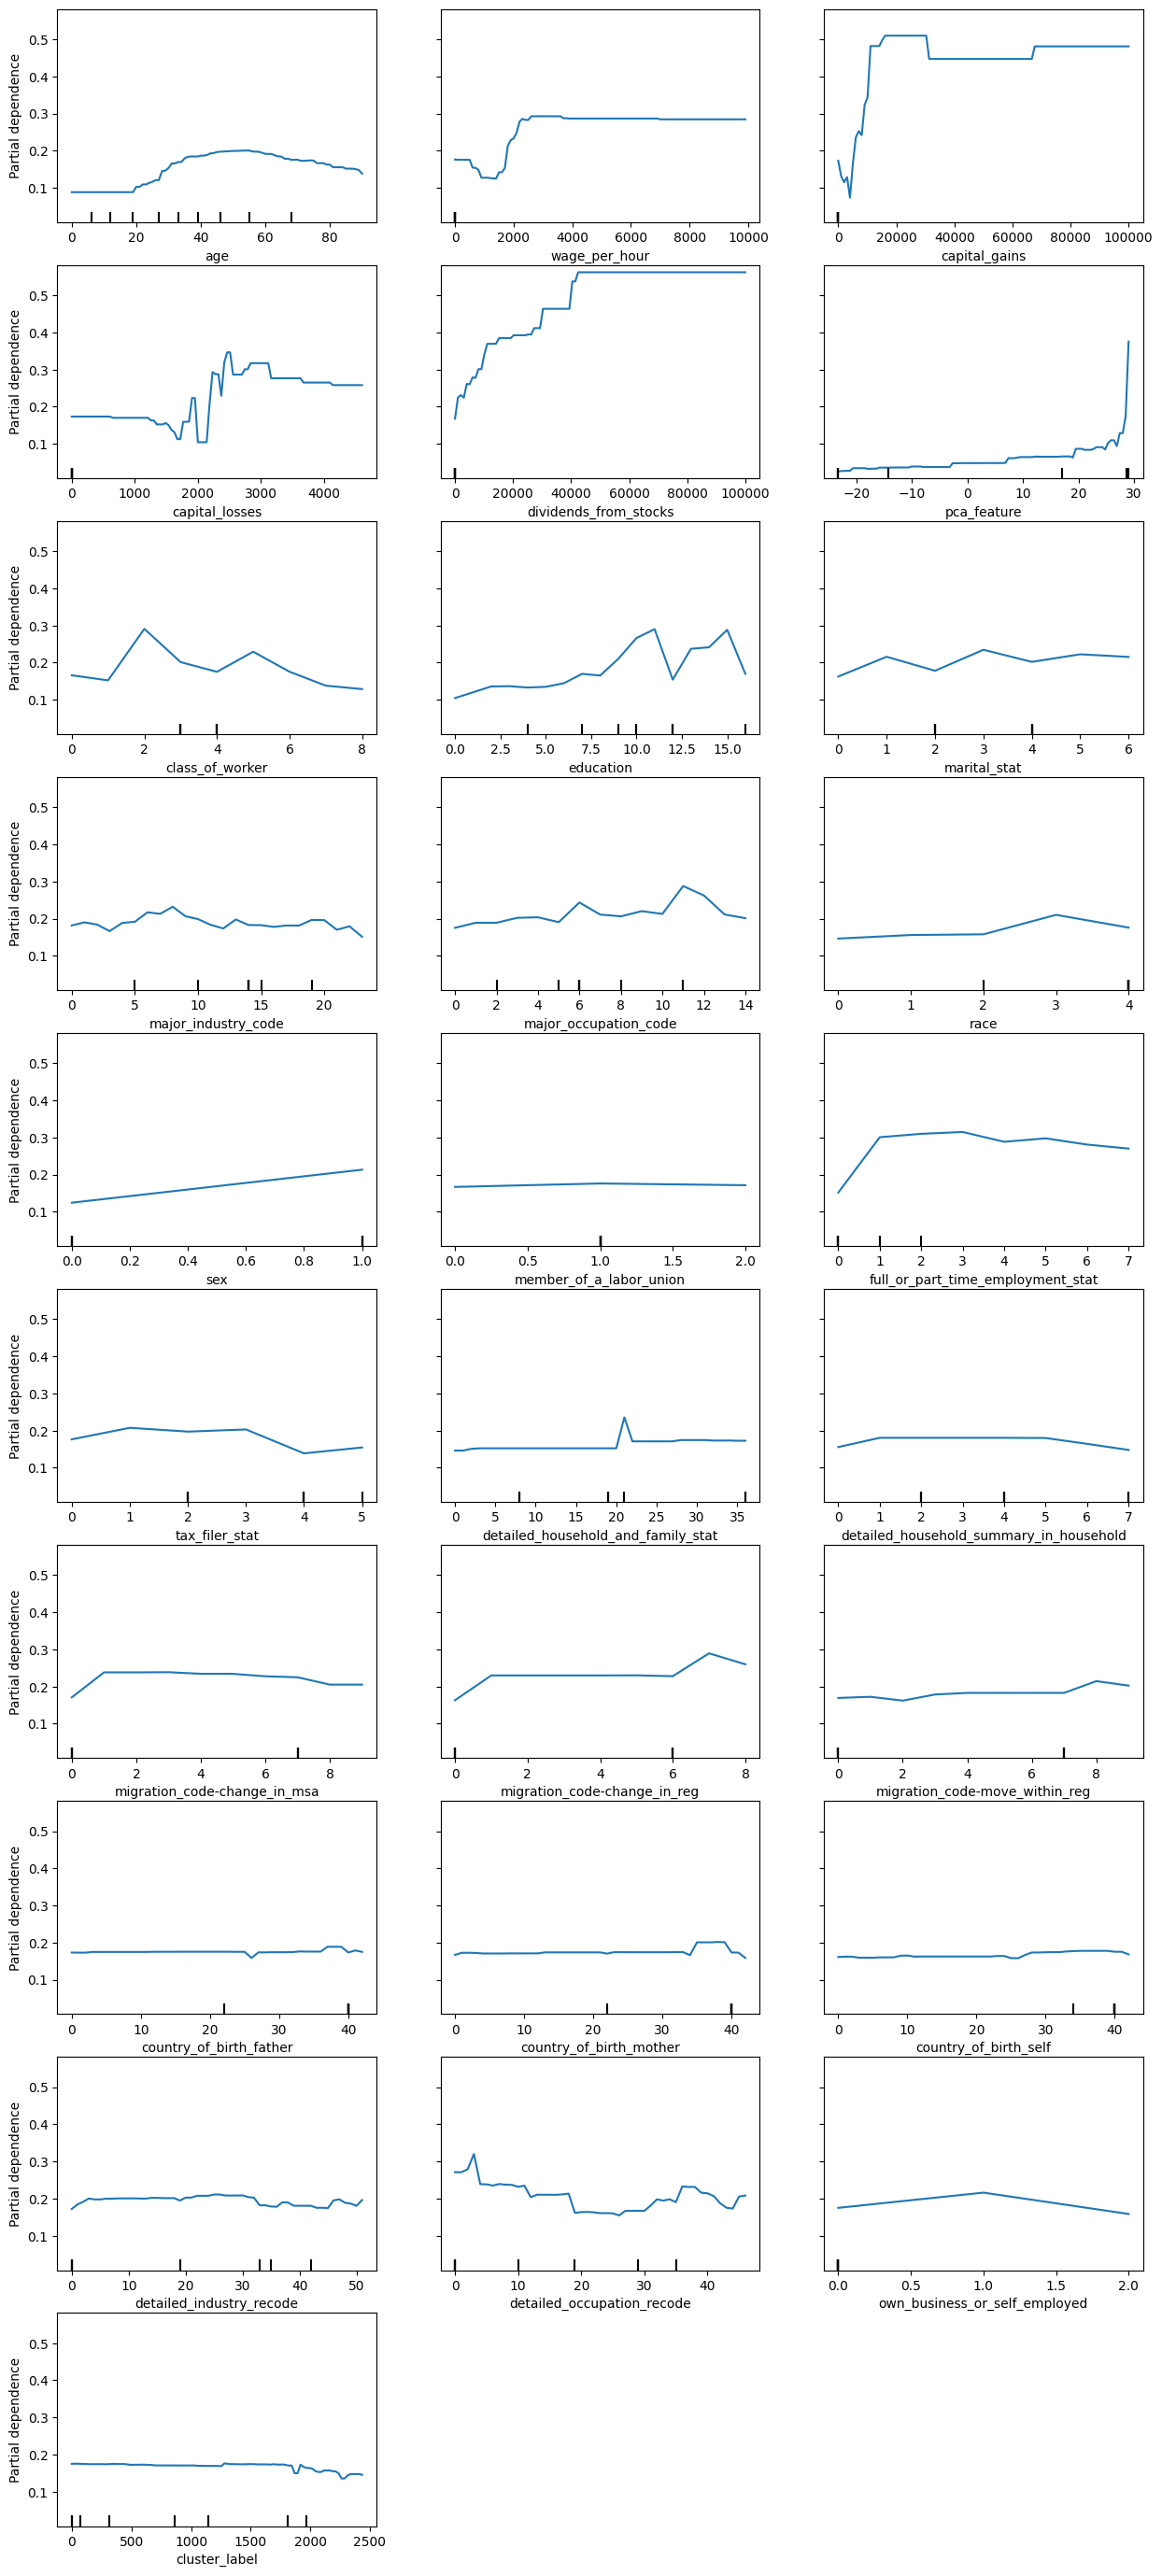

In [71]:
pdp(model, features)

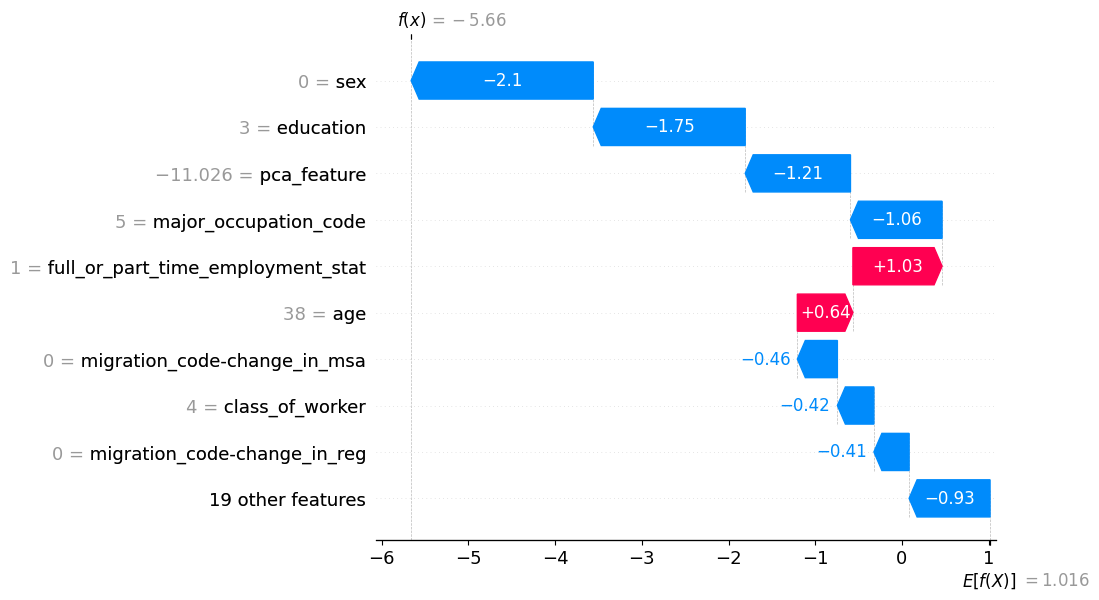

In [72]:
shap_plot(model)

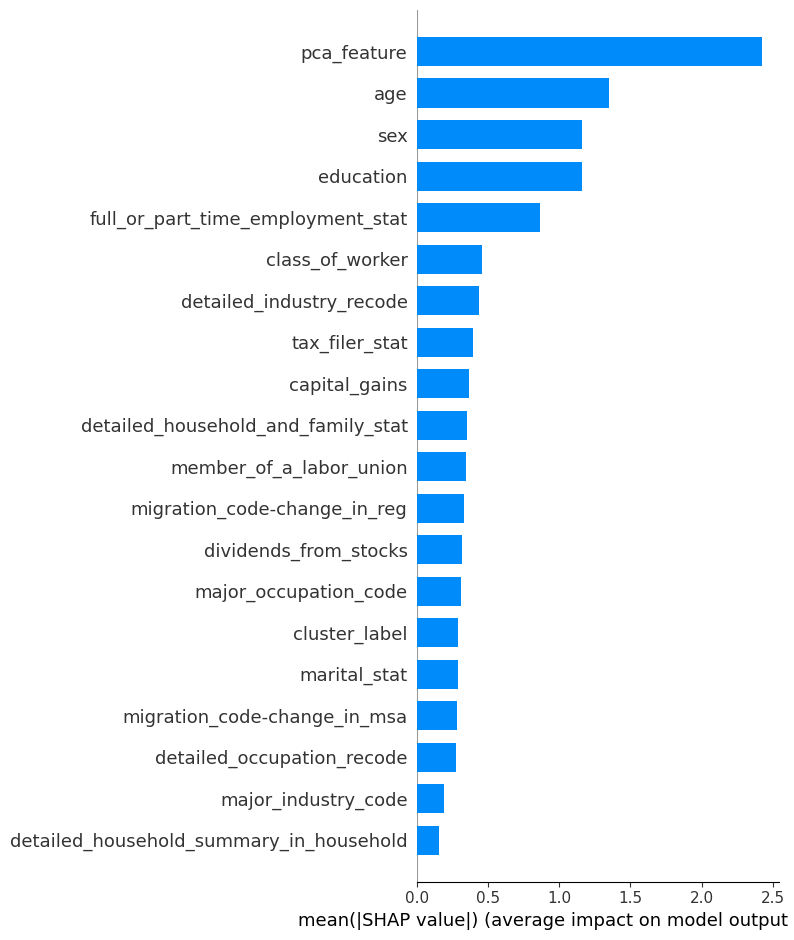

In [73]:
shap_summary_plot(model)

Now, let us interpret the ensemble.

In [74]:
model = stacking_model

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   7 out of  28 | elapsed:  4.4min remaining: 13.2min
[Parallel(n_jobs=-1)]: Done  17 out of  28 | elapsed:  7.1min remaining:  4.6min
[Parallel(n_jobs=-1)]: Done  28 out of  28 | elapsed: 11.0min finished


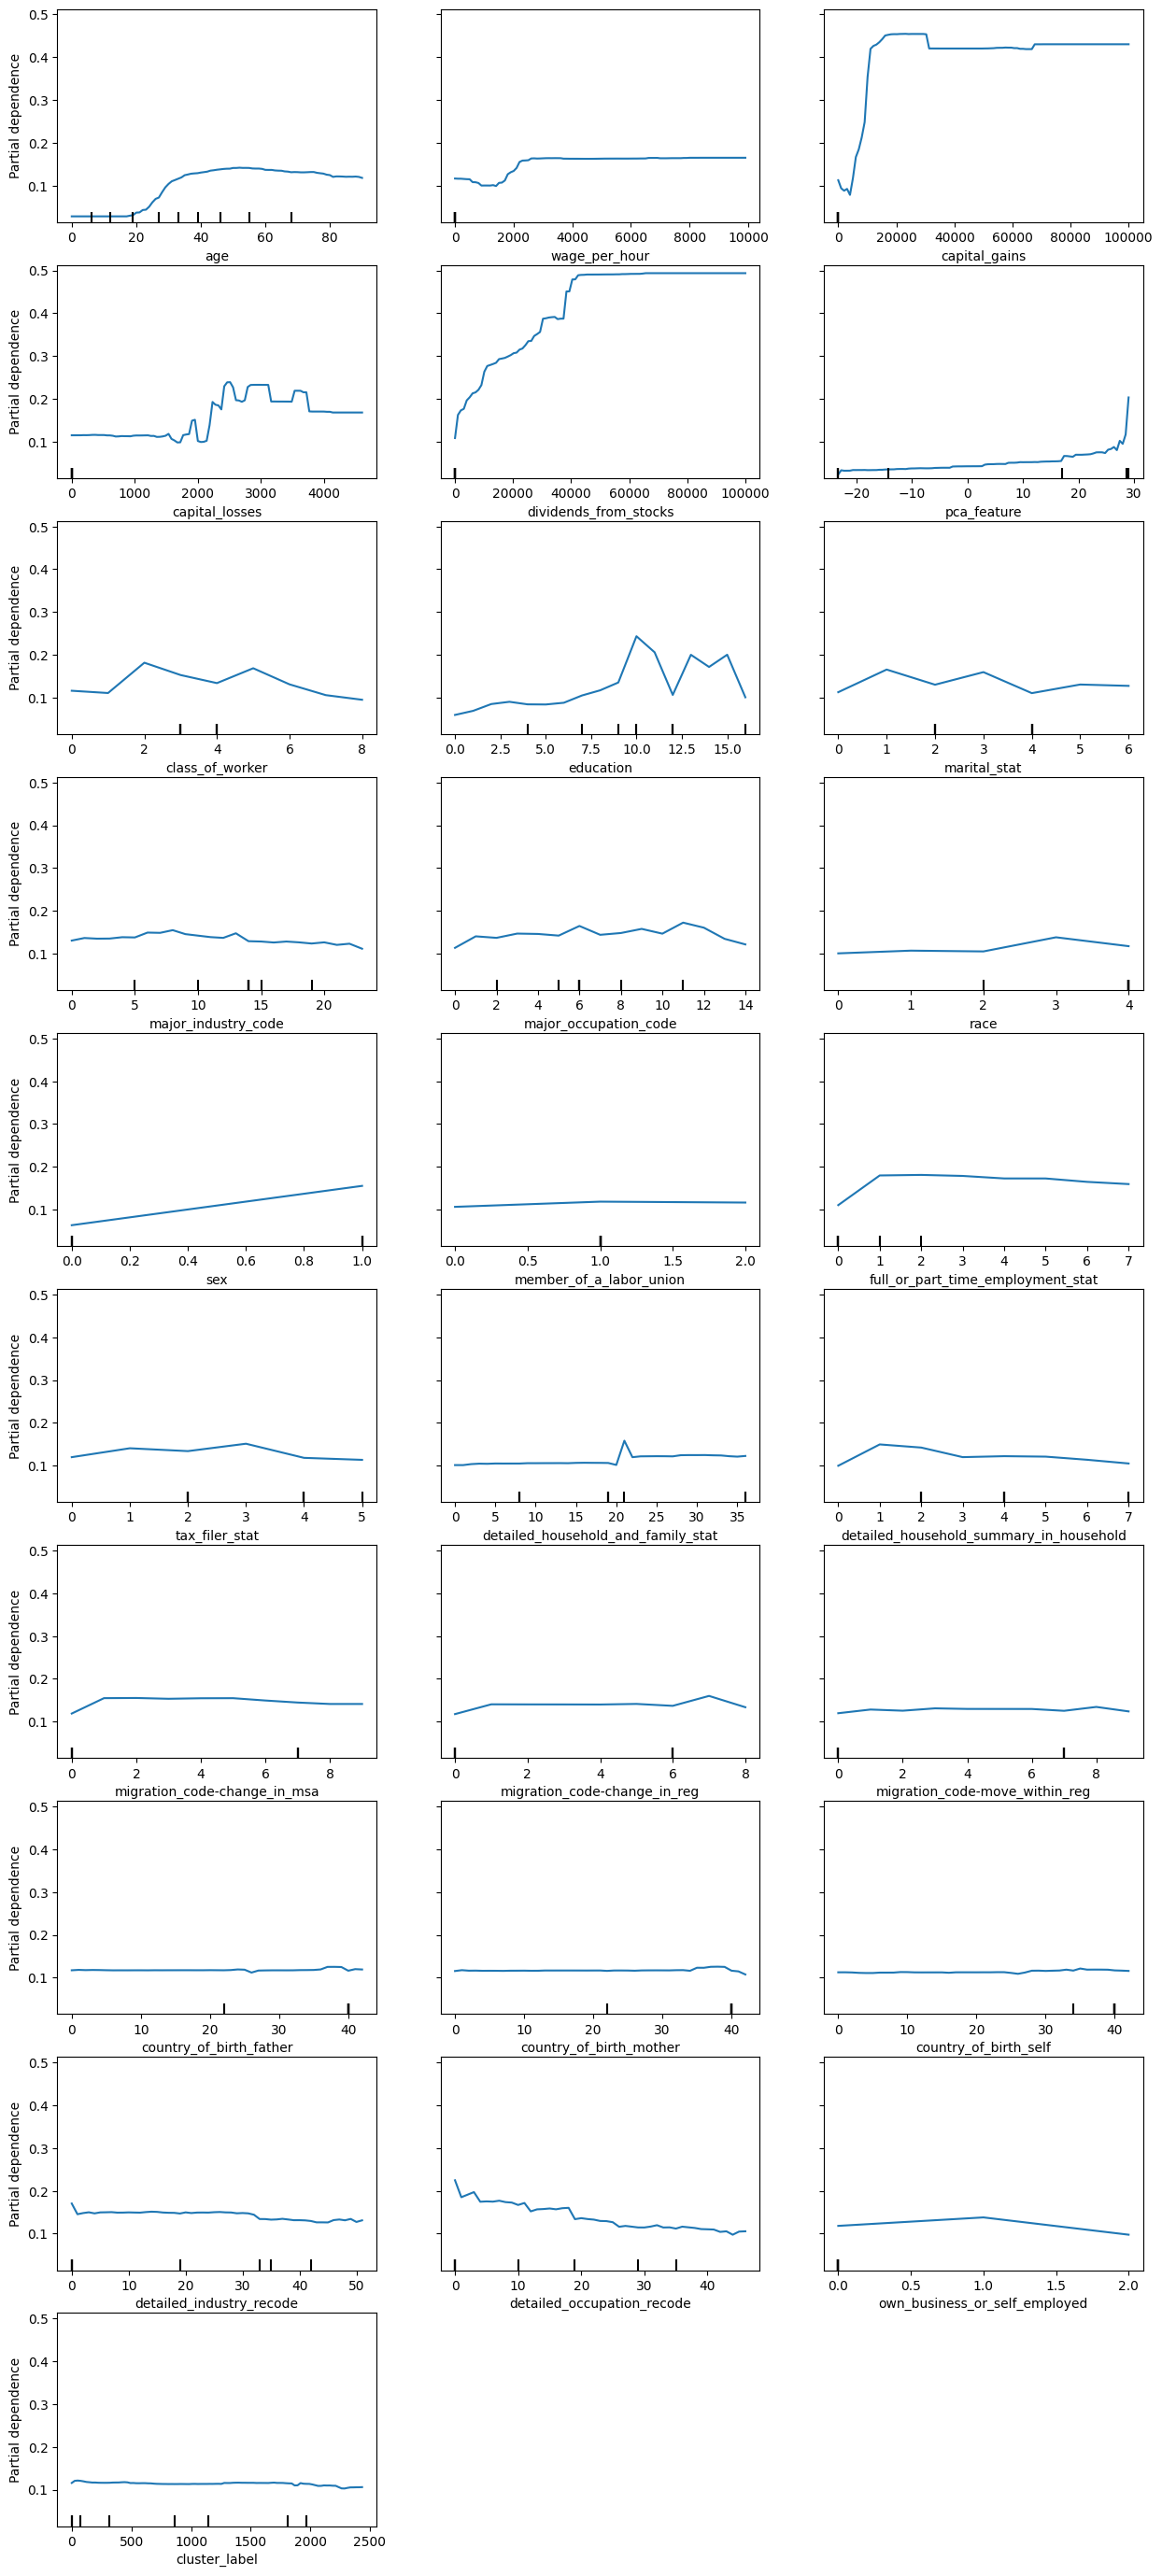

In [75]:
pdp(model, features)

In [76]:
def predict_fn(instances):
    predictions = model.predict(instances)
    return predictions

explainer = LimeTabularExplainer(training_data=X_train.values, mode='regression', feature_names=features)
explanation = explainer.explain_instance(X_test.iloc[0], predict_fn, num_features=len(features))
explanation.show_in_notebook(show_table=True)
explanation.as_list()

[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  96 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 256 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 300 out of 300 | elapsed:    0.0s finished


[('country_of_birth_self <= 40.00', 0.1565178439637617),
 ('country_of_birth_mother <= 40.00', 0.13517773351806558),
 ('33.00 < age <= 50.00', 0.08908329461180382),
 ('member_of_a_labor_union <= 1.00', 0.06704458617610096),
 ('country_of_birth_father <= 40.00', 0.06663069027392879),
 ('education <= 9.00', -0.06350690843363248),
 ('detailed_occupation_recode > 26.00', -0.06021816911428521),
 ('sex <= 0.00', -0.05094223713265907),
 ('marital_stat <= 2.00', -0.0479530895928848),
 ('dividends_from_stocks <= 0.00', -0.04707556966834789),
 ('capital_gains <= 0.00', -0.04448895585680047),
 ('detailed_household_and_family_stat > 27.00', 0.0370195539381553),
 ('own_business_or_self_employed <= 0.00', 0.036769194176321025),
 ('2.00 < tax_filer_stat <= 4.00', 0.03515989660197853),
 ('0.00 < detailed_industry_recode <= 33.00', -0.02142531982527582),
 ('0.00 < full_or_part_time_employment_stat <= 1.00', 0.01988273840820043),
 ('detailed_household_summary_in_household > 6.00', -0.014144920365120005)

Model quality explanation.

Our models have moderately good quality for now. We made certain steps to remove unnecesary features but still have some work to do. There are up to 6-8 features which require training but barely contribute to the classification task. Removing these features should increase model quality, facilitate faster learning and limit overfirring.

##### 4.3. Summary

What have you found in the data, which techniques did you use? Which methods and models worked best in your task? Can you explain in simple words why should we trust your final model?

The task data contains census information collected in the USA in 1994-1995. We were supposed to make binary classification.
The datasets contained 42 features including target. The data is highly imbalanced.


* In both train and test stes we have found more than 25% of duplicated records which we disided to keep.
* We have also found conflicting records in both sets, i.e. identical records falling into different classes.
* Among numerical features we have found two highly correlated features with Pearson correlation over 0.75.
* Four numerical were filled in with 0 and extreme values only, which we kept, counting on further anomaly detection.
---
* We have dropped 2 'ignore' features.
* In order to encode target label we used `Label Encodeding` which tranformed target values int 0s and 1s.
* The highly correlated features were transformed into one numerical feature using `PCA`.
* We have removed from both sets all conflicting records.
* Additionally we have applied anomaly detection using `Isolation Forest`. For this purpose we employed `WoE` target encoding.
* Feature selection was performed using `RFE` and `Random Forest Classifier` as base model.
* We have used `Ordinal Encoding` for categorical features. It's not the best choice as it adds to nominal categories some order or sense of continuity. The reason for this is that after employment of `WoE` we have got target leakage which resulted in overfitting and poor performance on the test set.
* We have performed clusterization using `HDBSCAN` and added cluster labels as a new feature to each dataset.
* Finally, we have applied  a combination of techniques for imbalanced data: oversampling technique `SMOTE` and undersampling technique `Tomek Links`. Besides we used an algorithmic technique by setting argument `class_weight='balanced'` while training one of models.
---
* For classification we have selected `LightGBM` Classifier, `CatBoost` Classifier, `Random Forest` Classifier.
* We have tuned hyper parameters using `Grid Search`.
* While training and validation we used `Cross Validation` strategy.
* The three models were stacked with the help of `Stacking Classifier`, optimal weights were computed using `Linear Regression`.
* The model with highest testing results was interpreted using `Partial Dependence Display` and  `SHAP`.
* The stacking model was interpreted using  `Partial Dependence Display` and  `Lime Tabular Explainer`.

We can improve the model by trying to remove all duplicates, decrease its dimensionality and consider another encoding approach which prevents overfitting and target leakage. Or we may consider running some classification models without preliminary encoding of categories if such model can directly deal with unencoded values. 

We should trust the final model because the whole process was logical and understandable: the data preparation and preprocessing was transparent and structured, model training hyperparameters were tuned to catch the best score and model interpretations showed the dependency behind the features and the target as well as possible way for further improvement.

### General Requirements

* You should provide a solution in the form of the Jupyter Notebook with code cells and markdown cells (with text)
* Make sure that the instructor can run all the cells to reproduce your results
* Clearly answer each question, perform the required actions from the task. Explain your decisions if you choose to use some techniques
* Support all your statements with calculations and plots. For instance, if you claim that the dataset does not have missing values, you need to provide the code which shows that the total number of missing values is zero